In [1]:
import string
import collections
import pandas as pd
import matplotlib.colors as mcolors
from gensim import corpora, models
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
# NLTK packages
from nltk import tokenize
from nltk.sentiment.util import *
from nltk.corpus import stopwords
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer, sent_tokenize, word_tokenize

### Retrieve the suspect file list

In [2]:
suspectFileList = []
with open('metadata/suspectInfo.txt', 'r') as f:
    for line in f.readlines():
        suspectName, followers, pattern = line.split(",")
        filename = "".join(suspectName.split())
        suspectFileList.append(f"{filename}.csv")

print("target files: \n")        
print(suspectFileList)

target files: 

['HarveyWeinstein.csv', 'LarryNassar.csv', 'CristianoRonaldo.csv', 'MarkHalperin.csv', 'NeildeGrasseTyson.csv', 'MattLauer.csv', 'RussellSimmons.csv', 'AlFranken.csv']


Get suspect pattern information for the stop word set

In [3]:
suspectPattern = {}
with open('metadata/suspectInfo.txt', 'r') as f:
    for line in f.readlines():
        suspectName, followers, pattern = line.split(",")
        filename = "".join(suspectName.split())
        suspectPattern[filename] = pattern.rstrip('\n')
        
print(suspectPattern)

{'HarveyWeinstein': 'Weinstein|HarveyWeinstein|Harvey Scissorhands|HarveyScissorhands', 'LarryNassar': 'Larry Nassar|Larry_Nassar|LarryNassar|Nassar ', 'CristianoRonaldo': 'Cristiano Ronald|CristianoRonald|Cr7|Cristiano Ronaldo dos Santos Aveiro ', 'MarkHalperin': 'Mark Halperin|MarkHalperin|Halperin', 'NeildeGrasseTyson': '@neiltyson|Neil deGrasse Tyson|deGrasse|haydenplanetarium.org/tyson/', 'MattLauer': 'Matt Lauer|MattLauer|Lauer', 'RussellSimmons': 'Russell Simmons|UncleRUSH', 'AlFranken': 'Al Franken|alfranken'}


### Import external stopword file and checkout stopword list
initialize basic stopword set and add more stopwords from extension file

In [4]:
stopWords = set(stopwords.words('english'))

# add more stop words from extension file
with open('metadata/stopWords.txt', 'r') as f:
    for word in f.readlines():
        w = word.strip("\n")
        stopWords.add(w)

stopWords.add('rt')
stopWords.add('…')

for p in string.punctuation:
    stopWords.add(p)

print(len(stopWords))
print(stopWords)

519
{'others', 'because', 'together', 'doesn', 'hasn', 'last', 'needing', 'like', 'does', 'ours', 'had', 'all', 'than', 'l', 'her', 'to', 'grouping', 'where', 'should', 'face', "haven't", 'working', 'even', "wouldn't", '&', 'new', 'ever', 'put', 'let', 'ways', 'back', 'other', 'nor', 'certainly', 'opens', '@', 'finds', 'presents', '%', 'k', 'each', 'wasn', 'best', 'places', 've', '+', 'take', "didn't", '\\', 'below', 'general', 'pointing', 'was', 'anybody', 'cases', 'parting', 'said', "hadn't", 'differ', 'of', 'few', 'turned', 'generally', 'you', 'having', 'w', 'became', 'group', 'took', '!', 'which', 'hers', 'another', 'everybody', 'about', 'any', 'different', 'get', 'u', 'what', 'over', 'known', 'per', 'backed', 'behind', 'a', 'too', 'man', 'parts', 'some', 't', 'areas', 'this', 'kind', 'h', 'second', 'going', 'among', 'non', 'want', 'm', 'greatest', "couldn't", 'are', 'doing', 'ain', 'latest', 'shan', 'above', 'went', 'knew', "should've", 'sure', 'cannot', 'longer', 'possible', 'eve

### Read the dataframe from suspect CSV file
read the csv data as dataframe and rename the column

In [5]:
suspectMap = {}

for fileName in suspectFileList:
    suspectName = "".join(fileName.split(".")[0])
    df = pd.read_csv(f'cleaned/sentiment_analysis/{fileName}')
    df = df.rename(columns = {'retweet_screen_name':'orgName'})    
    suspectMap[suspectName] = (df, df.values.tolist())
    print(f"transfer {suspectName} into dataframe")

transfer HarveyWeinstein into dataframe
transfer LarryNassar into dataframe
transfer CristianoRonaldo into dataframe
transfer MarkHalperin into dataframe
transfer NeildeGrasseTyson into dataframe
transfer MattLauer into dataframe
transfer RussellSimmons into dataframe
transfer AlFranken into dataframe


## Setup function for sentiment analysis

In [6]:
def label_sentiment(row):
    # helper function to label the sentiment score 
    cutoff = 0.05
    if row.compound <= -1 * cutoff:
        return "neg"
    elif row.compound >= cutoff:
        return "pos"
    
    return "neu"

def getTokenizedText(df, col='text') -> list:
    # tokenize the text and return
    text = df[col]
    exclude = set(string.punctuation)
    tokenized, tokenizer = [], TweetTokenizer()

    for doc in text:
        tokens = tokenizer.tokenize(doc.lower())
        tokenized.append(''.join([ch for ch in ' '.join(tokens) if ch not in exclude]).split())
    
    filtered, tokList = [], []
    # join target to sentences
    for j, sent in enumerate(tokenized):
        concat = [i for i in sent if i not in stopWords and len(i) > 2]
        if concat:
            filtered.append(" ".join(concat))
            tokList.append(concat)
            
    return filtered, tokList

def getSentimentScore(tokenizedText):
    # use input tokenized text to generate sentiment score dataframe
    # get sentiment score using vader
    sid = SentimentIntensityAnalyzer()
    scores = []
    for sentence in tokenizedText:
        data = sid.polarity_scores(sentence)
        data['text'] = sentence
        scores += [data]
    
    sentScoreDF = pd.DataFrame(scores)
    return sentScoreDF


## Setup function for retreiving sentiment score based on [organization/ community]

In [7]:
def filterStopWords(text):
    tmp = []
    tweetWord = word_tokenize(text.replace("\n", " "))
    for w in tweetWord:
        if w.lower() in stopWords:
            continue
        tmp.append(w)
    
    return " ".join(tmp) # append the new concatenated string

In [8]:
def getOrgSentimentScore(tweets):
    posThreshold = 0.05
    negThreshold = -0.05
    
    score = collections.defaultdict(lambda: collections.defaultdict(list))
    counter = collections.defaultdict(list)
    sid = SentimentIntensityAnalyzer()
    
    for usrId, tweet, org in set(tweets):
        ss = sid.polarity_scores(tweet) # score dict
        counter[org].append((ss['pos'], ss['neg'], ss['neu'])) # {org: [(pos, neg, neu)]}
            
        if ss['compound'] >= posThreshold: 
            # positive case
            score[org]['pos'].append((ss['pos'], len(tweet), tweet, ss))
        elif ss['compound'] <= negThreshold: 
            # negative case
            score[org]['neg'].append((ss['neg'], len(tweet), tweet, ss))
        else:
            # neutral case
            score[org]['neu'].append((ss['neu'], len(tweet), tweet, ss))
        

    return score, counter
        
def getSentMap(tweets):
    memo = collections.defaultdict(list)

    posThreshold = 0.05
    negThreshold = -0.05

    for usrId, tweet, org in set(tweets):
        sid = SentimentIntensityAnalyzer()
        ss = sid.polarity_scores(tweet) # score dict
        # print(tweet)

        if ss['compound'] >= posThreshold: 
            # positive case
            memo['pos'].append((ss['pos'], len(tweet), tweet, ss))
        elif ss['compound'] <= negThreshold: 
            # negative case
            memo['neg'].append((ss['neg'], len(tweet), tweet, ss))
        else:
            # neutral case
            memo['neu'].append((ss['neu'], len(tweet), tweet, ss))

        # print(f"compound: {ss['compound']}, pos: {ss['pos']}, neg: {ss['neg']}, neu: {ss['neu']}\n")
    return memo

def getAvg(scoreList):
    posSum = negSum = neuSum = 0
    totalNum = len(scoreList)
    
    for pos, neg, neu in scoreList:
        posSum += pos
        negSum += neg
        neuSum += neu
        
    return posSum / totalNum, negSum / totalNum, neuSum / totalNum

In [9]:
def sentimentScoreByOrg(suspectList):
    tweets = []
    target = suspectList
    for usrId, text, retweetId, org in target:
        item = (usrId, filterStopWords(text), org)
        tweets.append(item)

    score, counter = getOrgSentimentScore(tweets)
    top5 = sorted(counter, key=lambda k: len(counter[k]), reverse=True)[:5]
    orgList = []

    for i, org in enumerate(top5):
        pos, neg, neu = getAvg(counter[org])
        orgList.append(org)
        print(f"top {i+1} organization/community: {org}")
        print(f"number of retweets: {len(counter[org])}")
        print(f"avg positive score: {pos}, avg negative score: {neg}, avg neutral score: {neu}")
        print("==============================\n")
        
    return score, orgList

### top k positive / negative / neutral tweets

In [10]:
import heapq

def topKFrequent(target, tag="positive", k=5):
    minHeap = []
    
    for obj in target:
        score, length, txt, scoreList = obj
        if not valid(txt):
            # check if tweet text is valid in our customized rule
            continue

        heapq.heappush(minHeap, (score, length, obj))
        while len(minHeap) > k:
            heapq.heappop(minHeap)
    
    res = []   
    while minHeap:
        res.append(heapq.heappop(minHeap)[-1])

    for i, item in enumerate(res[::-1]):
        score, length, txt, scoreList = item
        print(f"top {i+1} {tag} tweet")
        print(txt)
        print(f"tweet length: {length}")
        print(f"score: {scoreList}\n")
        
def countHashTag(s):
    return len([c for c in s if c == '@'])

def valid(txt):
    # invalid if too many @ or text is too short 
    return countHashTag(txt) < len(txt) // 2 and len(txt) > 5

## Setup function for word cloud analysis
code reference: [Topic modeling visualization – How to present the results of LDA models?](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/)
<br>

**Our goal: find the crucial topic words in the LDA model of each suspect**

In [11]:
def getLdaModel(tokenizedText, topicNum=5, wordNum=5, no_below=5, no_above=0.3):
    dictionary = corpora.Dictionary(tokenizedText)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    dictionary.compactify()
    corpus = [dictionary.doc2bow(text) for text in tokenizedText]

    # build LDA model
    ldamodel = models.ldamodel.LdaModel(corpus, num_topics=4, id2word=dictionary, passes=20)
    ldamodel.print_topics(num_topics=topicNum, num_words=wordNum)
    return ldamodel

def wordCloudPlot(ldamodel, stopWords):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
    
    # generate word cloud
    cloud = WordCloud(stopwords=stopWords,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = ldamodel.show_topics(formatted=False)

    fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=500)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=24))
        plt.gca().axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

#### Word counts of topic keywords

consume the word count data and represent the relationship between word count and the importance of topic keywords

In [12]:
def ldaToDf(ldamodel, tokenizedText):
    topics = ldamodel.show_topics(formatted=False)
    data_flat = [w for w_list in tokenizedText for w in w_list]
    counter = collections.Counter(data_flat)

    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count']) 
    return df

def wordCountWeightPlot(df):
    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)    
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
    plt.show()
    

# Sentiment analysis case study for each target suspect

The primary sentiment analysis will be divided into the following three phases.

First, we **count the sentiment analysis label of each suspect** and discuss the results of the sentiment score<br>

Second, we screened the **community (organization comments) with the top three most prevalent discussions in all suspect data** and calculated sentiment scores to explore the attitudes or positions of these community members toward suspects.<br><br>
Finally, we made topic modeling for the text data of each suspect and analyzed and discussed the representative ones by **word cloud analysis**.

## Special Case study - Harvey Weinstein

In [13]:
targetDF, targetList = suspectMap["HarveyWeinstein"]
tokenizedText, tokList = getTokenizedText(targetDF)

#### sentiment analysis label counts

In [14]:
sentScore = getSentimentScore(tokenizedText)
sentScore["label"] = sentScore.apply(label_sentiment, axis=1)
display(sentScore)

,neg,neu,pos,compound,text,label
0,0.241,0.759,0.000,-0.5859,dhume india metoo moment mjakbar harvey weinst...,neg
1,0.000,1.000,0.000,0.0000,caropiquet depuis laffaire weinstein les plain...,neu
2,0.241,0.759,0.000,-0.5859,dhume india metoo moment mjakbar harvey weinst...,neg
3,0.000,1.000,0.000,0.0000,recovreputation metoo helped company reputatio...,neu
4,0.241,0.759,0.000,-0.5859,dhume india metoo moment mjakbar harvey weinst...,neg
...,...,...,...,...,...,...
8918,0.000,0.652,0.348,0.4939,unlockedn camip934 jezebel metoo weinstein fri...,pos
8919,0.189,0.811,0.000,-0.4215,slate spies lies harvey weinstein allies ronan...,neg
8920,0.189,0.811,0.000,-0.4215,slate spies lies harvey weinstein allies ronan...,neg
8921,0.189,0.811,0.000,-0.4215,slate spies lies harvey weinstein allies ronan...,neg


In [15]:
display(sentScore["label"].value_counts().to_frame().rename(columns = {'label':'count'}))
display(sentScore["label"].value_counts(normalize=True).to_frame().rename(columns = {'label':'ratio'}))

,count
neg,3834
neu,2621
pos,2468


,ratio
neg,0.429676
neu,0.293735
pos,0.276589


#### Sentiment analysis for top 5 [organization/community ] in each suspect

In [16]:
score, orgList = sentimentScoreByOrg(targetList)

top 1 organization/community: DonaldJTrumpJr
number of retweets: 735
avg positive score: 0.1899999999999984, avg negative score: 0.0949999999999992, avg neutral score: 0.7140000000000001

top 2 organization/community: jodikantor
number of retweets: 629
avg positive score: 0.28511923688394397, avg negative score: 0.0003004769475357711, avg neutral score: 0.7145802861685202

top 3 organization/community: dhume
number of retweets: 454
avg positive score: 0.0, avg negative score: 0.2259999999999993, avg neutral score: 0.7740000000000008

top 4 organization/community: rachelheldevans
number of retweets: 420
avg positive score: 0.0, avg negative score: 0.19499999999999873, avg neutral score: 0.8050000000000055

top 5 organization/community: MiKohiyama
number of retweets: 391
avg positive score: 0.0, avg negative score: 0.20816368286445056, avg neutral score: 0.7918363171355499



#### word cloud analysis for each suspect using pretrained LDA model

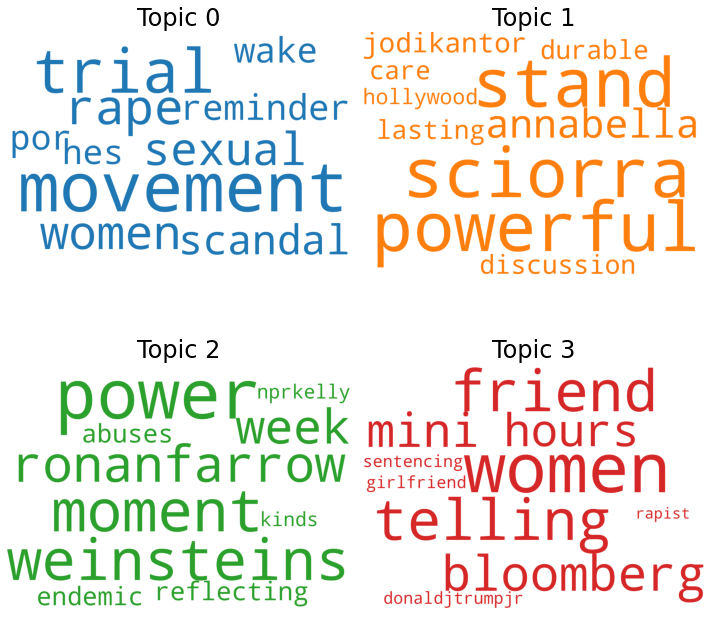

In [17]:
for word in suspectPattern["HarveyWeinstein"].split("|"):
    stopWords.add(word)
    
ldamodel = getLdaModel(tokList)
wordCloudPlot(ldamodel, stopWords)

/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalig

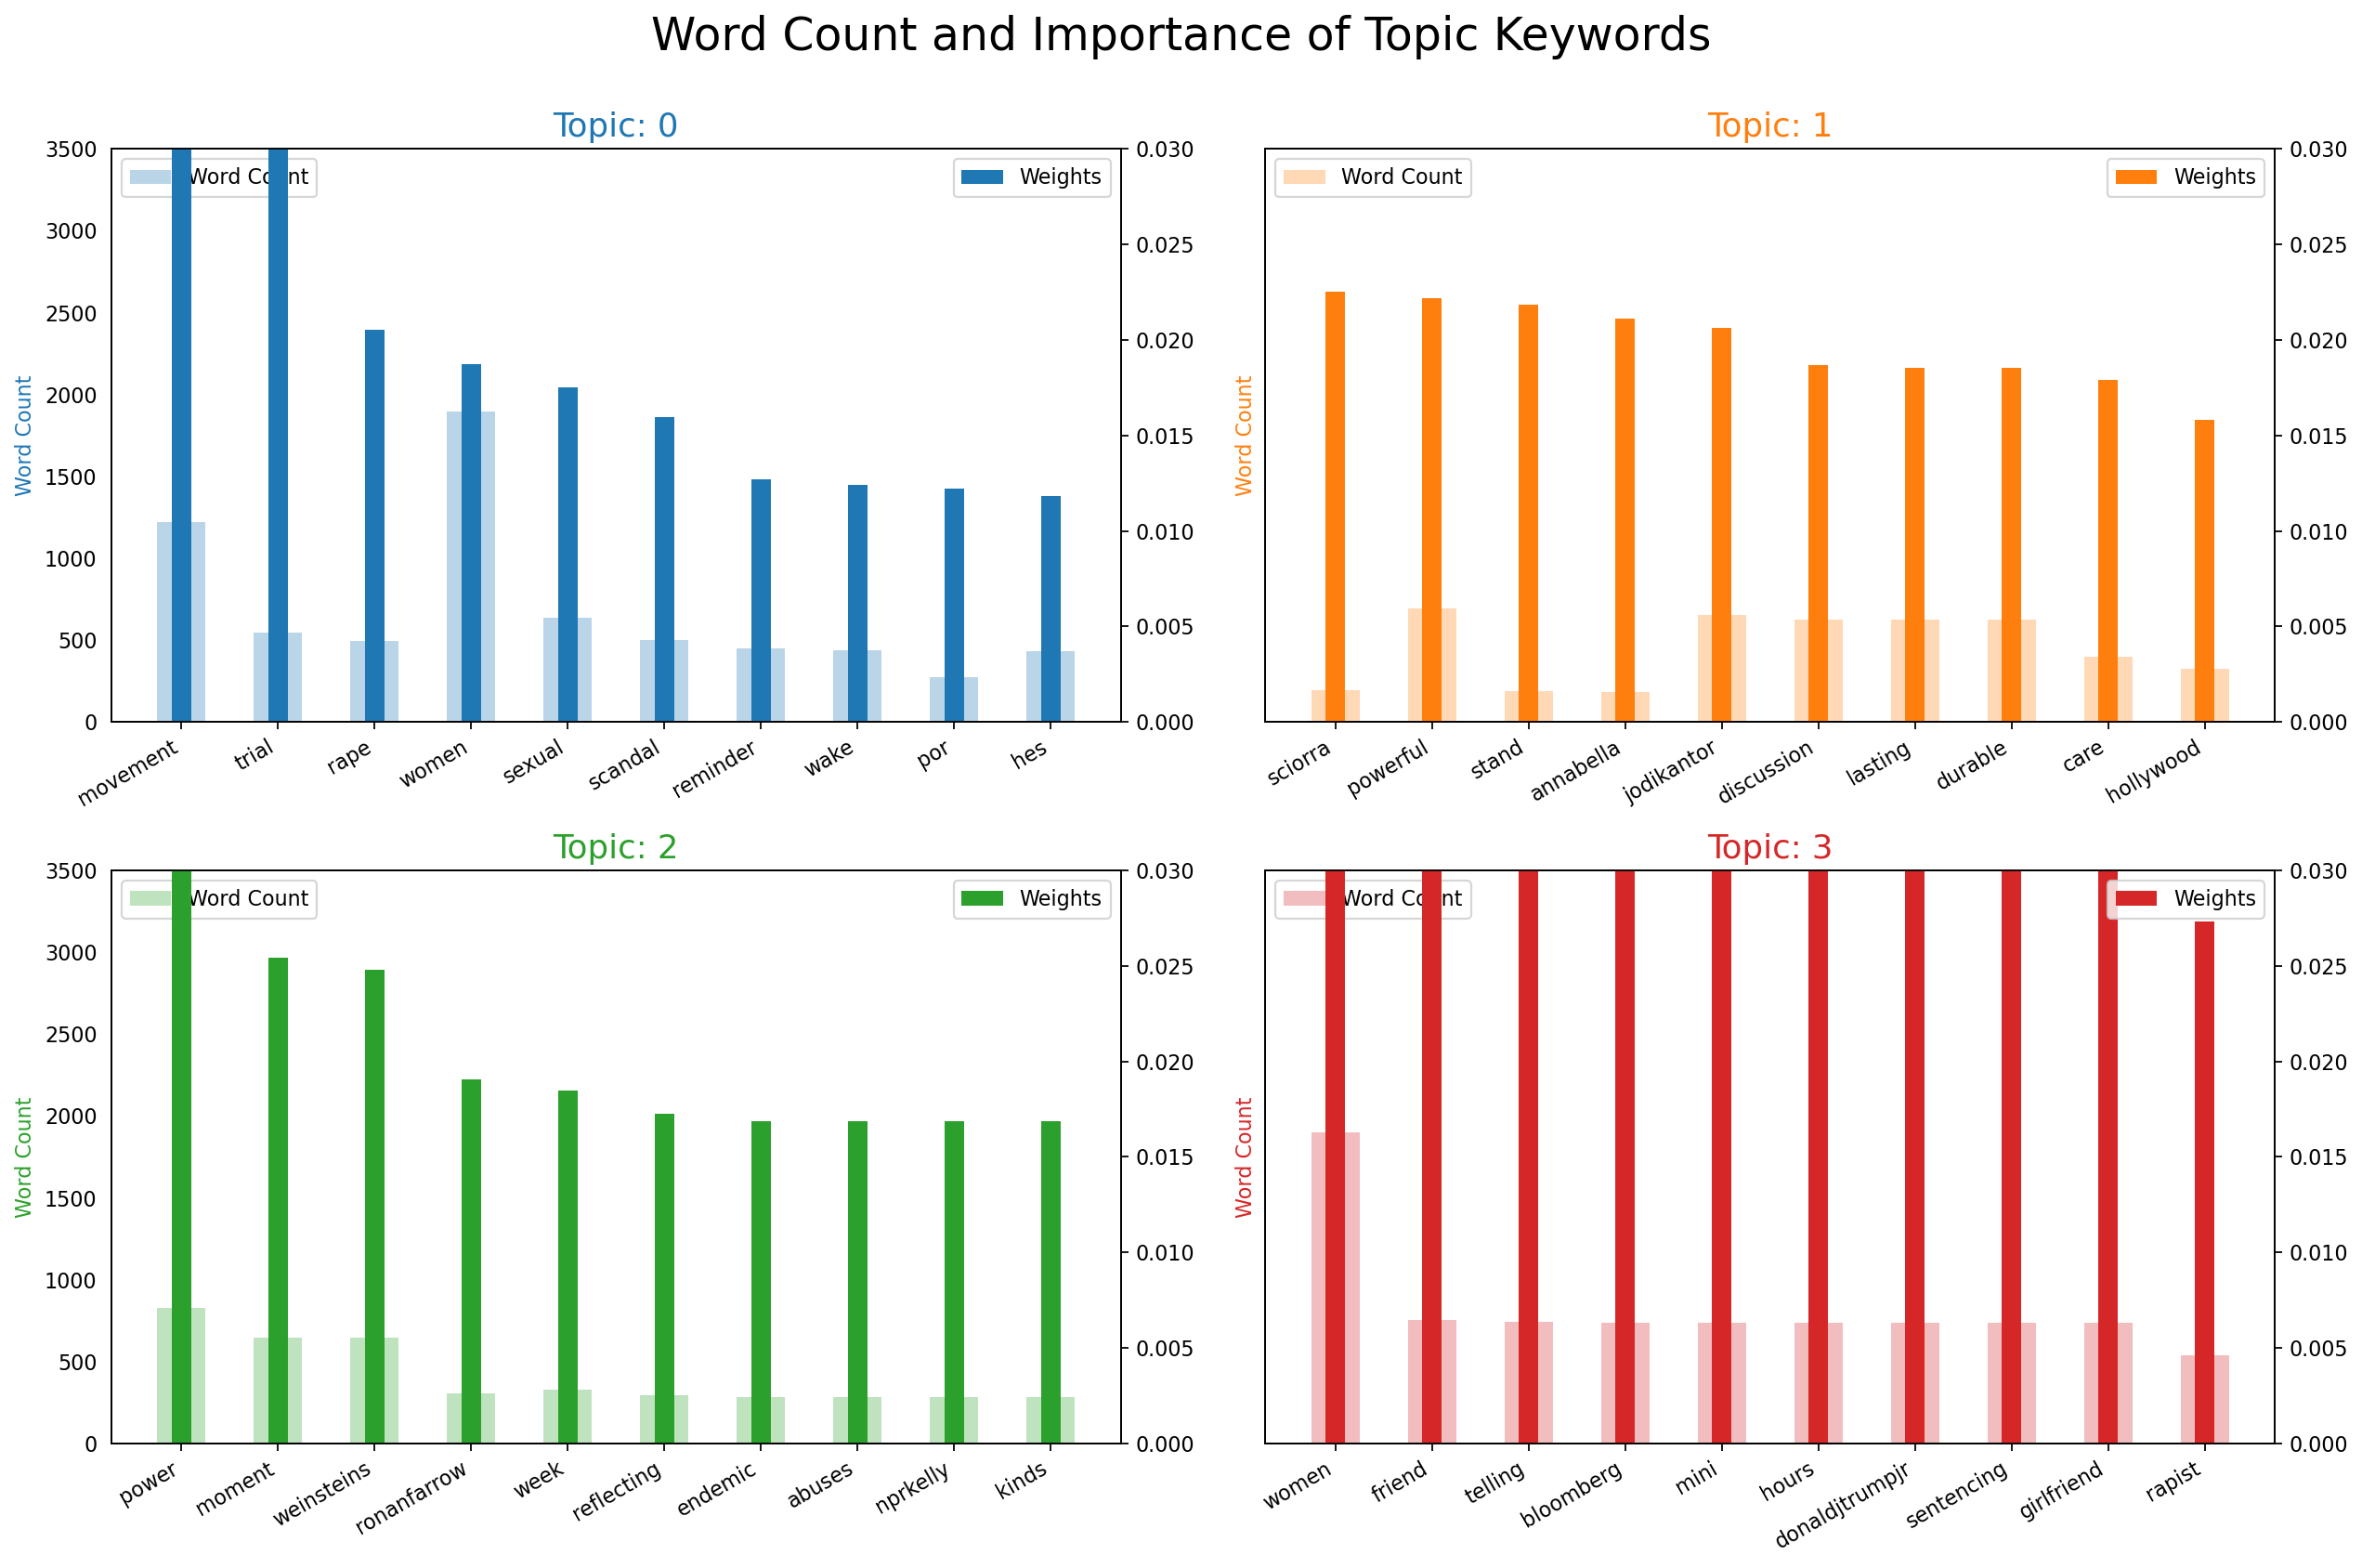

In [18]:
ldaDf = ldaToDf(ldamodel, tokList)
wordCountWeightPlot(ldaDf)

In [19]:
# clean up suspect-related stopwords
for word in suspectPattern["HarveyWeinstein"].split("|"):
    stopWords.remove(word)

## Special Case study - Cristiano Ronaldo

#### sentiment analysis label counts

In [20]:
targetDF, targetList = suspectMap["CristianoRonaldo"]
tokenizedText, tokList = getTokenizedText(targetDF)

In [21]:
sentScore = getSentimentScore(tokenizedText)
sentScore["label"] = sentScore.apply(label_sentiment, axis=1)
display(sentScore)

,neg,neu,pos,compound,text,label
0,0.000,1.000,0.000,0.0000,thegrumpydoctor ali zafar cristiano ronaldo al...,neu
1,0.261,0.507,0.232,-0.1027,rahulsinghcr7 aishwarya rai courage metoo seri...,neg
2,0.000,1.000,0.000,0.0000,brigadierpoez metoo httpstcoalcr78tc4w,neu
3,0.000,1.000,0.000,0.0000,ilfoglioit metoo era mai arrivato così alto or...,neu
4,0.000,1.000,0.000,0.0000,ajplusespanol policía las vegas emitido una or...,neu
...,...,...,...,...,...,...
389,0.000,1.000,0.000,0.0000,fuemiad 女性活躍推進本部長って 本当ならば女性の人選を守るお手本にならなきゃいけない...,neu
390,0.000,1.000,0.000,0.0000,fuemiad 女性活躍推進本部長って 本当ならば女性の人選を守るお手本にならなきゃいけない...,neu
391,0.337,0.523,0.140,-0.5267,gamerboy489 cristiano ronaldo proved innocent ...,neg
392,0.000,1.000,0.000,0.0000,vuamsterdam cristiano ronaldo ook neymar recen...,neu


In [22]:
display(sentScore["label"].value_counts().to_frame().rename(columns = {'label':'count'}))
display(sentScore["label"].value_counts(normalize=True).to_frame().rename(columns = {'label':'ratio'}))

,count
neu,208
neg,173
pos,13


,ratio
neu,0.527919
neg,0.439086
pos,0.032995


#### Sentiment analysis for top 5 [organization/community ] in each suspect

In [23]:
score, orgList = sentimentScoreByOrg(targetList)

top 1 organization/community: oeste
number of retweets: 58
avg positive score: 0.08100000000000004, avg negative score: 0.2569999999999998, avg neutral score: 0.6619999999999997

top 2 organization/community: mike_fusco
number of retweets: 29
avg positive score: 0.0, avg negative score: 0.0, avg neutral score: 1.0

top 3 organization/community: thinkprogress
number of retweets: 22
avg positive score: 0.0, avg negative score: 0.29900000000000015, avg neutral score: 0.7010000000000001

top 4 organization/community: AFPespanol
number of retweets: 17
avg positive score: 0.0, avg negative score: 0.0, avg neutral score: 1.0

top 5 organization/community: CNNEE
number of retweets: 16
avg positive score: 0.0, avg negative score: 0.0, avg neutral score: 1.0



#### word cloud analysis for each suspect using pretrained LDA model

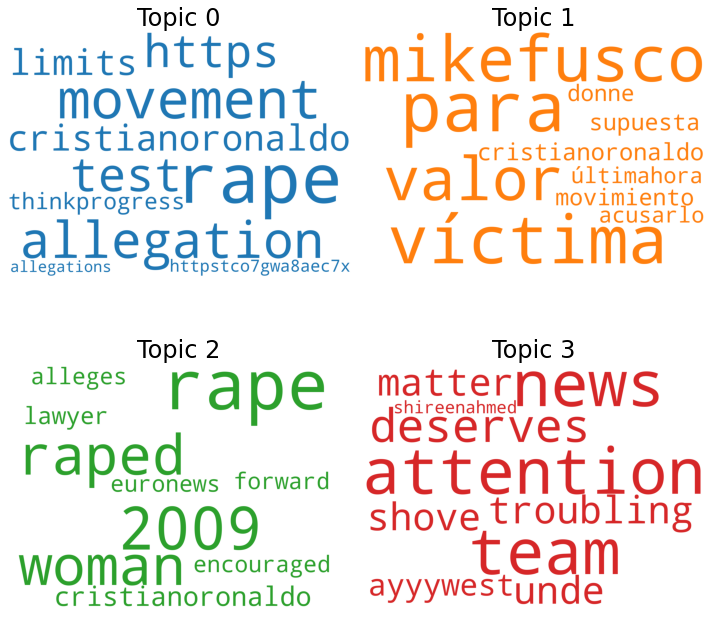

In [24]:
for word in suspectPattern["CristianoRonaldo"].split("|"):
    stopWords.add(word)
    
ldamodel = getLdaModel(tokList)
wordCloudPlot(ldamodel, stopWords)

/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalig

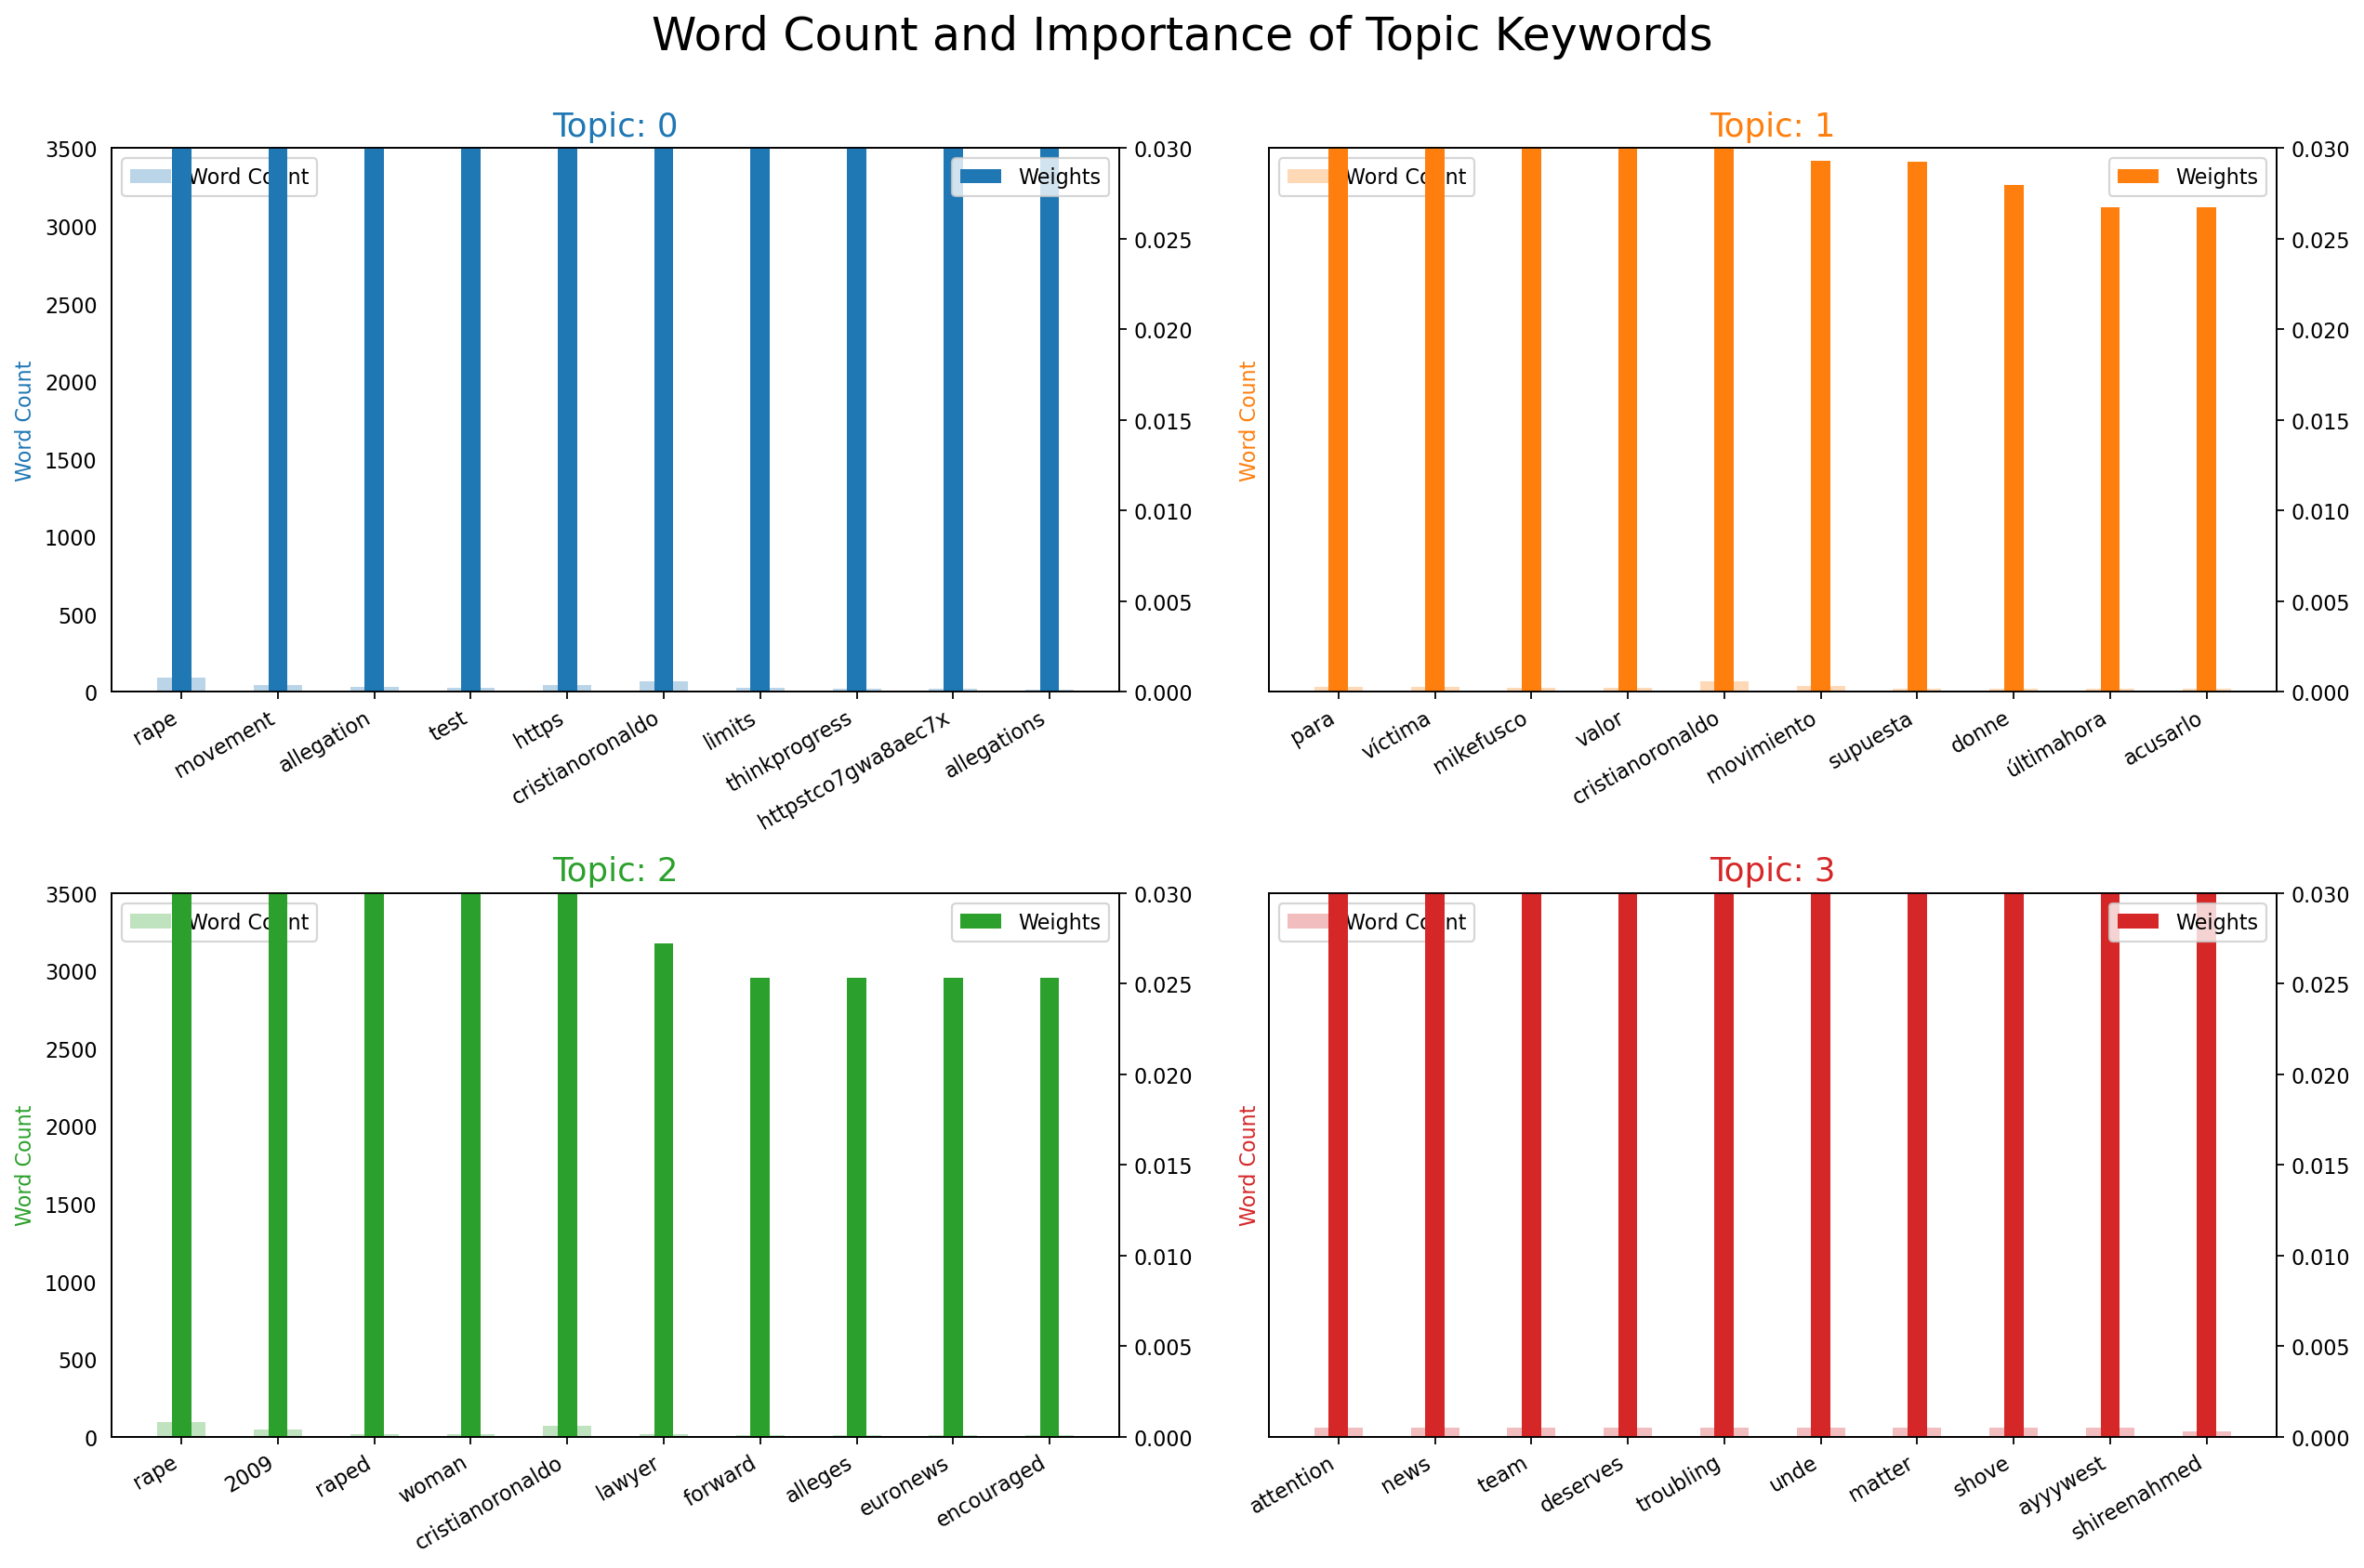

In [25]:
ldaDf = ldaToDf(ldamodel, tokList)
wordCountWeightPlot(ldaDf)

In [26]:
# clean up suspect-related stopwords
for word in suspectPattern["CristianoRonaldo"].split("|"):
    stopWords.remove(word)

## Russell Simmons

#### sentiment analysis label counts

In [27]:
targetDF, targetList = suspectMap["RussellSimmons"]
tokenizedText, tokList = getTokenizedText(targetDF)

In [28]:
sentScore = getSentimentScore(tokenizedText)
sentScore["label"] = sentScore.apply(label_sentiment, axis=1)
display(sentScore)

,neg,neu,pos,compound,text,label
0,0.000,0.685,0.315,0.5574,bnicole729 teamkanyedaily russell simmons wann...,pos
1,0.000,0.685,0.315,0.5574,bnicole729 teamkanyedaily russell simmons wann...,pos
2,0.000,0.685,0.315,0.5574,bnicole729 teamkanyedaily russell simmons wann...,pos
3,0.000,0.685,0.315,0.5574,bnicole729 teamkanyedaily russell simmons wann...,pos
4,0.000,0.685,0.315,0.5574,bnicole729 teamkanyedaily russell simmons wann...,pos
...,...,...,...,...,...,...
141,0.299,0.701,0.000,-0.6908,sillai wrote joyann reids reported piece detai...,neg
142,0.299,0.701,0.000,-0.6908,sillai wrote joyann reids reported piece detai...,neg
143,0.299,0.701,0.000,-0.6908,sillai wrote joyann reids reported piece detai...,neg
144,0.299,0.701,0.000,-0.6908,sillai wrote joyann reids reported piece detai...,neg


In [29]:
display(sentScore["label"].value_counts().to_frame().rename(columns = {'label':'count'}))
display(sentScore["label"].value_counts(normalize=True).to_frame().rename(columns = {'label':'ratio'}))

,count
neg,51
neu,48
pos,47


,ratio
neg,0.349315
neu,0.328767
pos,0.321918


#### Sentiment analysis for top 5 [organization/community ] in each suspect

In [30]:
score, orgList = sentimentScoreByOrg(targetList)

top 1 organization/community: ReignOfApril
number of retweets: 29
avg positive score: 0.2000000000000001, avg negative score: 0.0, avg neutral score: 0.8000000000000004

top 2 organization/community: DionneGrant
number of retweets: 22
avg positive score: 0.0, avg negative score: 0.0, avg neutral score: 1.0

top 3 organization/community: Sil_Lai
number of retweets: 17
avg positive score: 0.0, avg negative score: 0.29400000000000004, avg neutral score: 0.7060000000000002

top 4 organization/community: Frances_Fisher
number of retweets: 15
avg positive score: 0.02293333333333333, avg negative score: 0.20453333333333326, avg neutral score: 0.7725333333333333

top 5 organization/community: MoreAndAgain
number of retweets: 10
avg positive score: 0.0, avg negative score: 0.0, avg neutral score: 1.0



#### word cloud analysis for each suspect using pretrained LDA model

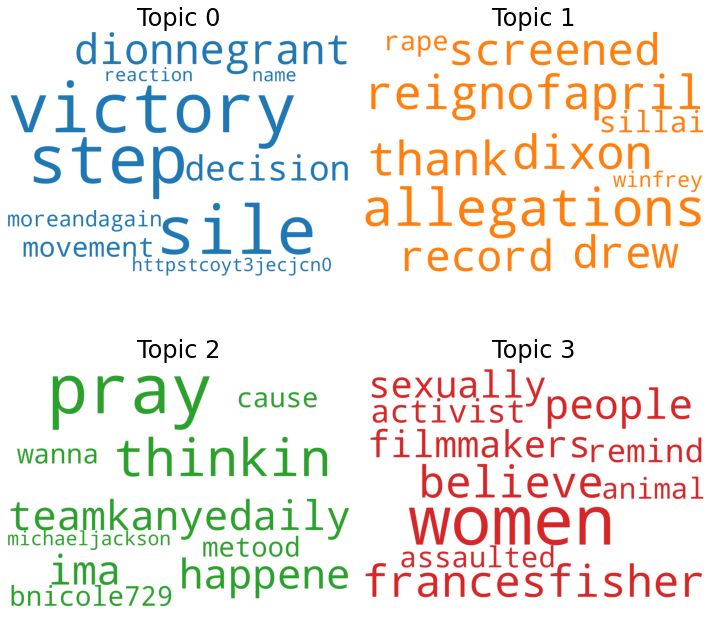

In [31]:
for word in suspectPattern["RussellSimmons"].split("|"):
    stopWords.add(word)
    
ldamodel = getLdaModel(tokList)
wordCloudPlot(ldamodel, stopWords)

/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalig

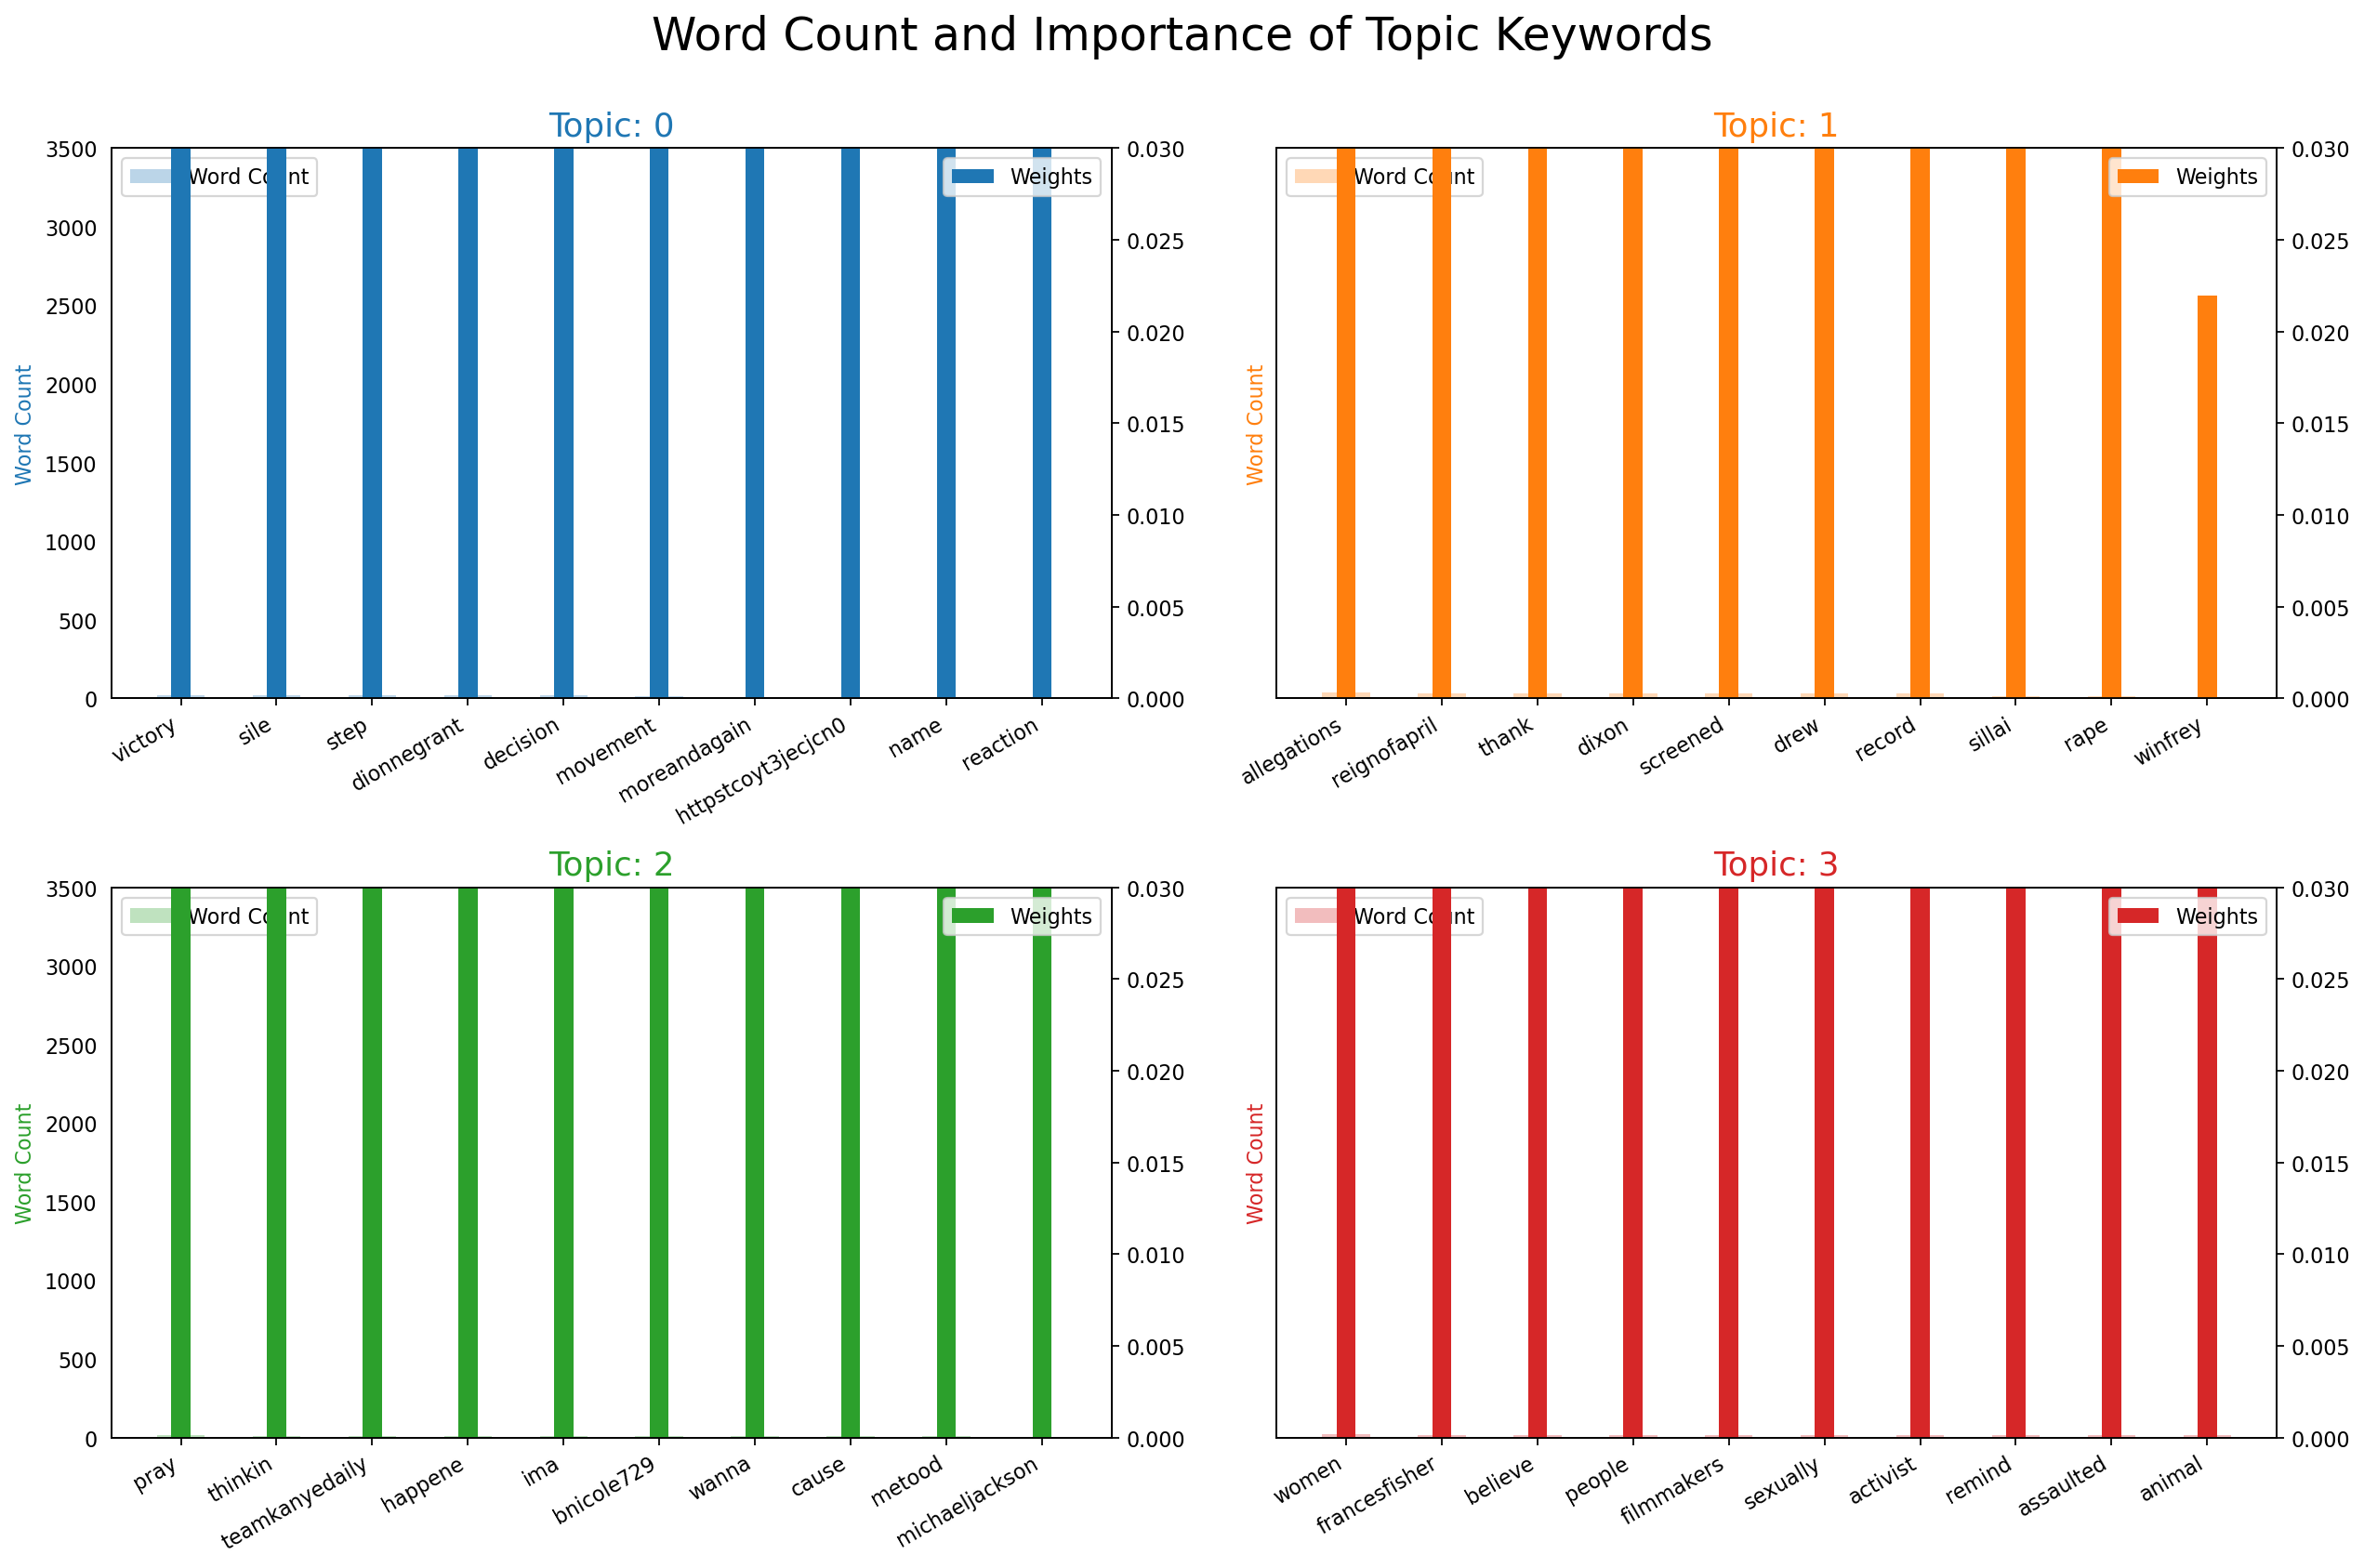

In [32]:
ldaDf = ldaToDf(ldamodel, tokList)
wordCountWeightPlot(ldaDf)

In [33]:
# clean up suspect-related stopwords
for word in suspectPattern["RussellSimmons"].split("|"):
    stopWords.remove(word)

## Al Franken

#### sentiment analysis label counts

In [34]:
targetDF, targetList = suspectMap["AlFranken"]
tokenizedText, tokList = getTokenizedText(targetDF)

In [35]:
sentScore = getSentimentScore(tokenizedText)
sentScore["label"] = sentScore.apply(label_sentiment, axis=1)
display(sentScore)

,neg,neu,pos,compound,text,label
0,0.247,0.753,0.000,-0.3182,howeasyweforget robert123511 alfranken nystate...,neg
1,0.174,0.826,0.000,-0.2732,no1 sen franken victim hunting witches hunting...,neg
2,0.247,0.753,0.000,-0.3182,howeasyweforget robert123511 alfranken nystate...,neg
3,0.247,0.753,0.000,-0.3182,howeasyweforget robert123511 alfranken nystate...,neg
4,0.247,0.753,0.000,-0.3182,howeasyweforget robert123511 alfranken nystate...,neg
...,...,...,...,...,...,...
283,0.141,0.859,0.000,-0.2023,smithmullin woman comes forward ninth accuse s...,neg
284,0.112,0.699,0.189,0.2732,musicstuffnmore fiercedimples arlenparsa miss ...,pos
285,0.318,0.529,0.153,-0.4215,doxiebaby sen alfranken forced resign comedian...,neg
286,0.318,0.529,0.153,-0.4215,doxiebaby sen alfranken forced resign comedian...,neg


In [36]:
display(sentScore["label"].value_counts().to_frame().rename(columns = {'label':'count'}))
display(sentScore["label"].value_counts(normalize=True).to_frame().rename(columns = {'label':'ratio'}))

,count
neg,173
neu,95
pos,20


,ratio
neg,0.600694
neu,0.329861
pos,0.069444


#### Sentiment analysis for top 5 [organization/community ] in each suspect

In [37]:
score, orgList = sentimentScoreByOrg(targetList)

top 1 organization/community: tizzywoman
number of retweets: 76
avg positive score: 0.0, avg negative score: 0.21599999999999978, avg neutral score: 0.7839999999999993

top 2 organization/community: LegalWeed4SC
number of retweets: 33
avg positive score: 0.0, avg negative score: 0.2110000000000001, avg neutral score: 0.7890000000000004

top 3 organization/community: texasrecks
number of retweets: 32
avg positive score: 0.0, avg negative score: 0.0, avg neutral score: 1.0

top 4 organization/community: CNNEE
number of retweets: 13
avg positive score: 0.0, avg negative score: 0.0, avg neutral score: 1.0

top 5 organization/community: RedState
number of retweets: 12
avg positive score: 0.0, avg negative score: 0.12800000000000003, avg neutral score: 0.872



#### word cloud analysis for each suspect using pretrained LDA model

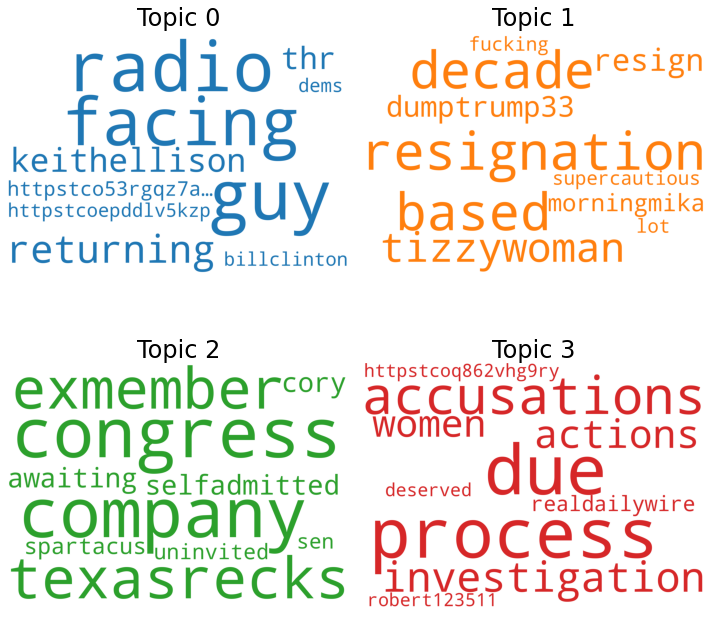

In [38]:
for word in suspectPattern["AlFranken"].split("|"):
    stopWords.add(word)
    
ldamodel = getLdaModel(tokList)
wordCloudPlot(ldamodel, stopWords)

/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalig

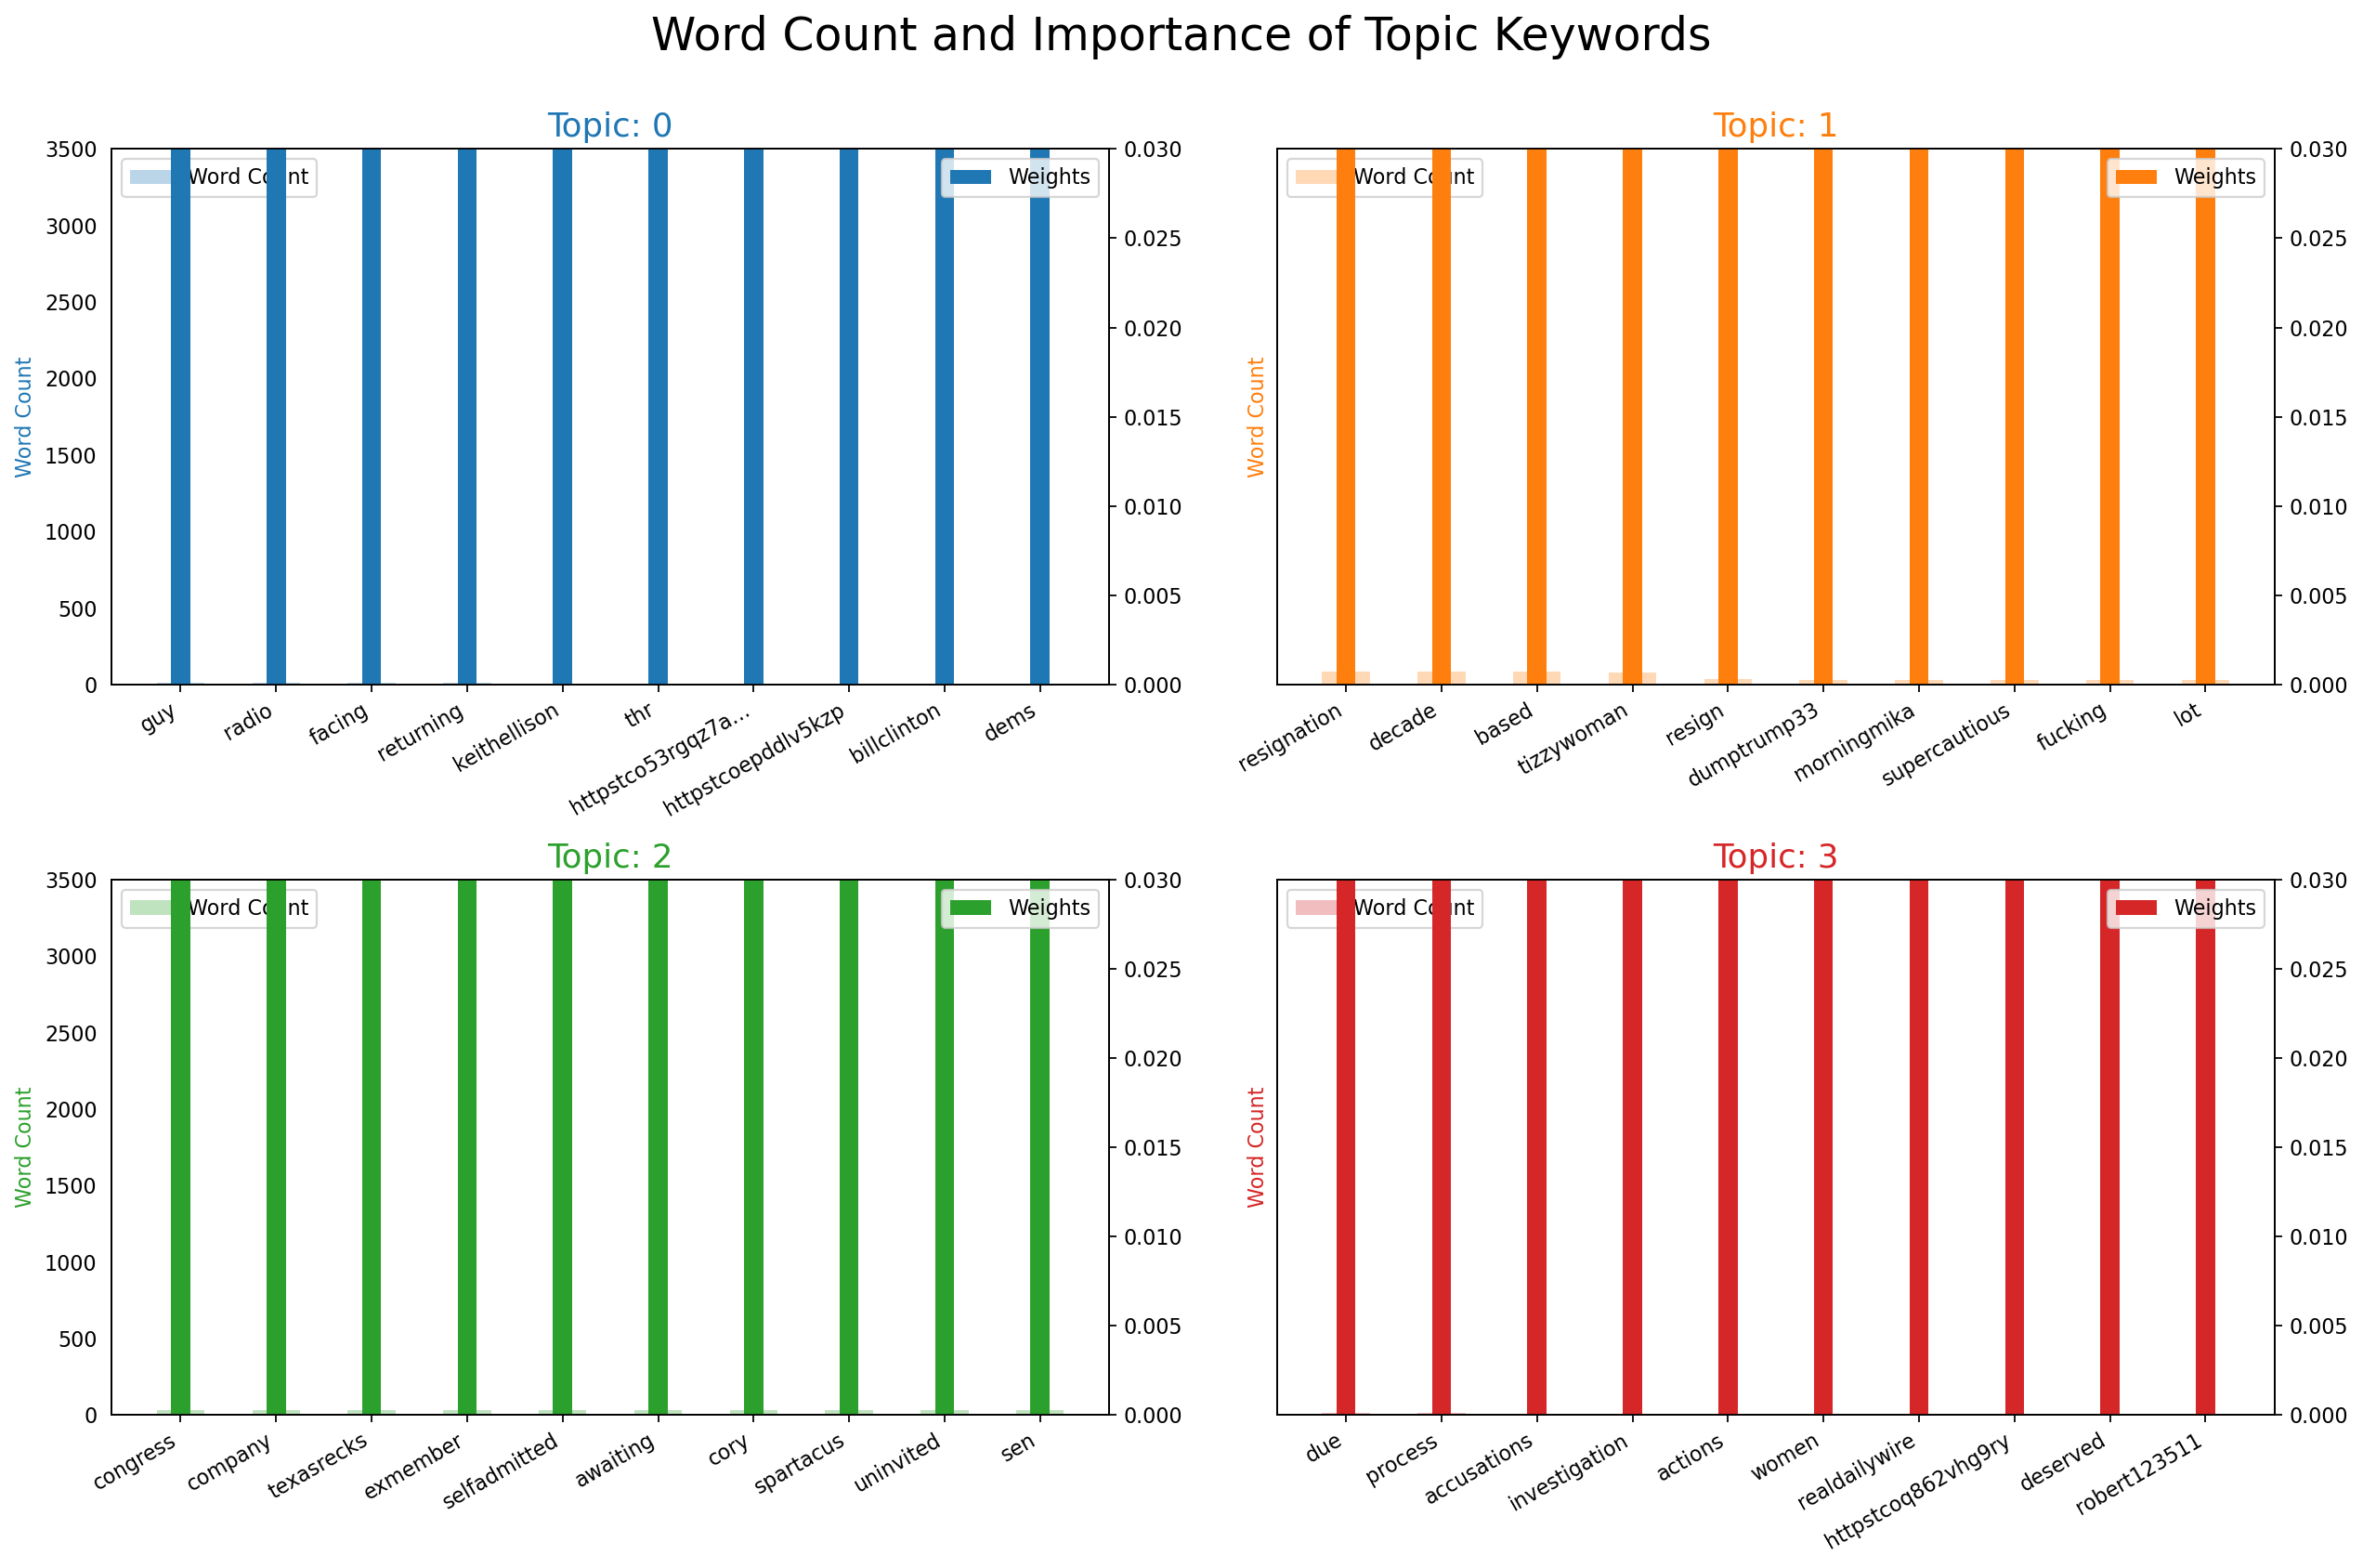

In [39]:
ldaDf = ldaToDf(ldamodel, tokList)
wordCountWeightPlot(ldaDf)

In [40]:
# clean up suspect-related stopwords
for word in suspectPattern["AlFranken"].split("|"):
    stopWords.remove(word)

## Larry Nassar

#### sentiment analysis label counts

In [41]:
targetDF, targetList = suspectMap["LarryNassar"]
tokenizedText, tokList = getTokenizedText(targetDF)

In [42]:
sentScore = getSentimentScore(tokenizedText)
sentScore["label"] = sentScore.apply(label_sentiment, axis=1)
display(sentScore)

,neg,neu,pos,compound,text,label
0,0.000,1.000,0.000,0.0000,polenbergm biggest lesson stillunfolding web e...,neu
1,0.000,1.000,0.000,0.0000,polenbergm biggest lesson stillunfolding web e...,neu
2,0.000,1.000,0.000,0.0000,polenbergm biggest lesson stillunfolding web e...,neu
3,0.000,1.000,0.000,0.0000,polenbergm biggest lesson stillunfolding web e...,neu
4,0.000,1.000,0.000,0.0000,polenbergm biggest lesson stillunfolding web e...,neu
...,...,...,...,...,...,...
187,0.315,0.685,0.000,-0.8316,dlfsport simonebiles ist die beste turnerin de...,neg
188,0.161,0.839,0.000,-0.3182,sexabusenews girls chronicles testimonies larr...,neg
189,0.425,0.458,0.118,-0.6908,gracealexwatch abused larry nassar admit damag...,neg
190,0.535,0.300,0.165,-0.8555,bernemuthien abused larry nassar admit damage ...,neg


In [43]:
display(sentScore["label"].value_counts().to_frame().rename(columns = {'label':'count'}))
display(sentScore["label"].value_counts(normalize=True).to_frame().rename(columns = {'label':'ratio'}))

,count
neu,115
neg,68
pos,9


,ratio
neu,0.598958
neg,0.354167
pos,0.046875


#### Sentiment analysis for top 5 [organization/community ] in each suspect

In [44]:
score, orgList = sentimentScoreByOrg(targetList)

top 1 organization/community: TashaSchwikert
number of retweets: 70
avg positive score: 0.0, avg negative score: 0.18900000000000003, avg neutral score: 0.811

top 2 organization/community: devdevnumnums
number of retweets: 29
avg positive score: 0.2069999999999999, avg negative score: 0.48799999999999966, avg neutral score: 0.3049999999999999

top 3 organization/community: PolenbergM
number of retweets: 21
avg positive score: 0.0, avg negative score: 0.0, avg neutral score: 1.0

top 4 organization/community: DianaHowles
number of retweets: 15
avg positive score: 0.0, avg negative score: 0.3870000000000001, avg neutral score: 0.6129999999999998

top 5 organization/community: DLF_Sport
number of retweets: 13
avg positive score: 0.0, avg negative score: 0.315, avg neutral score: 0.6850000000000003



#### word cloud analysis for each suspect using pretrained LDA model

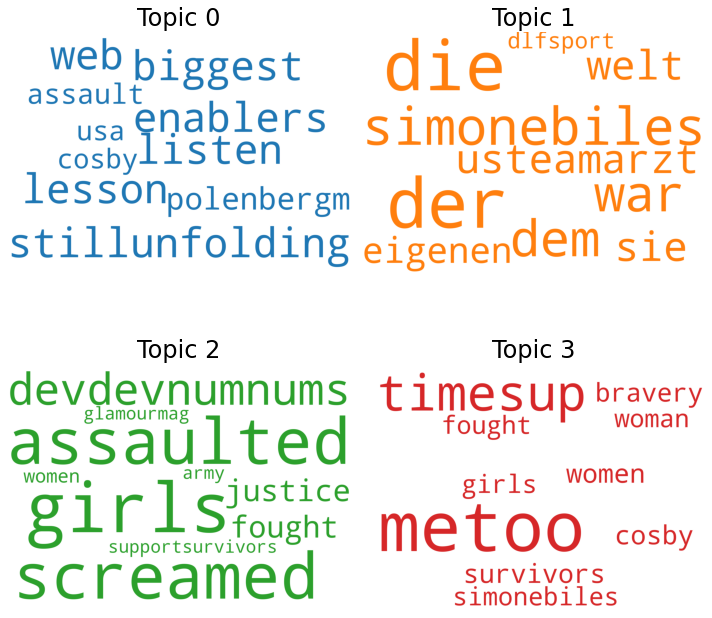

In [45]:
for word in suspectPattern["LarryNassar"].split("|"):
    stopWords.add(word)
    
ldamodel = getLdaModel(tokList)
wordCloudPlot(ldamodel, stopWords)

/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalig

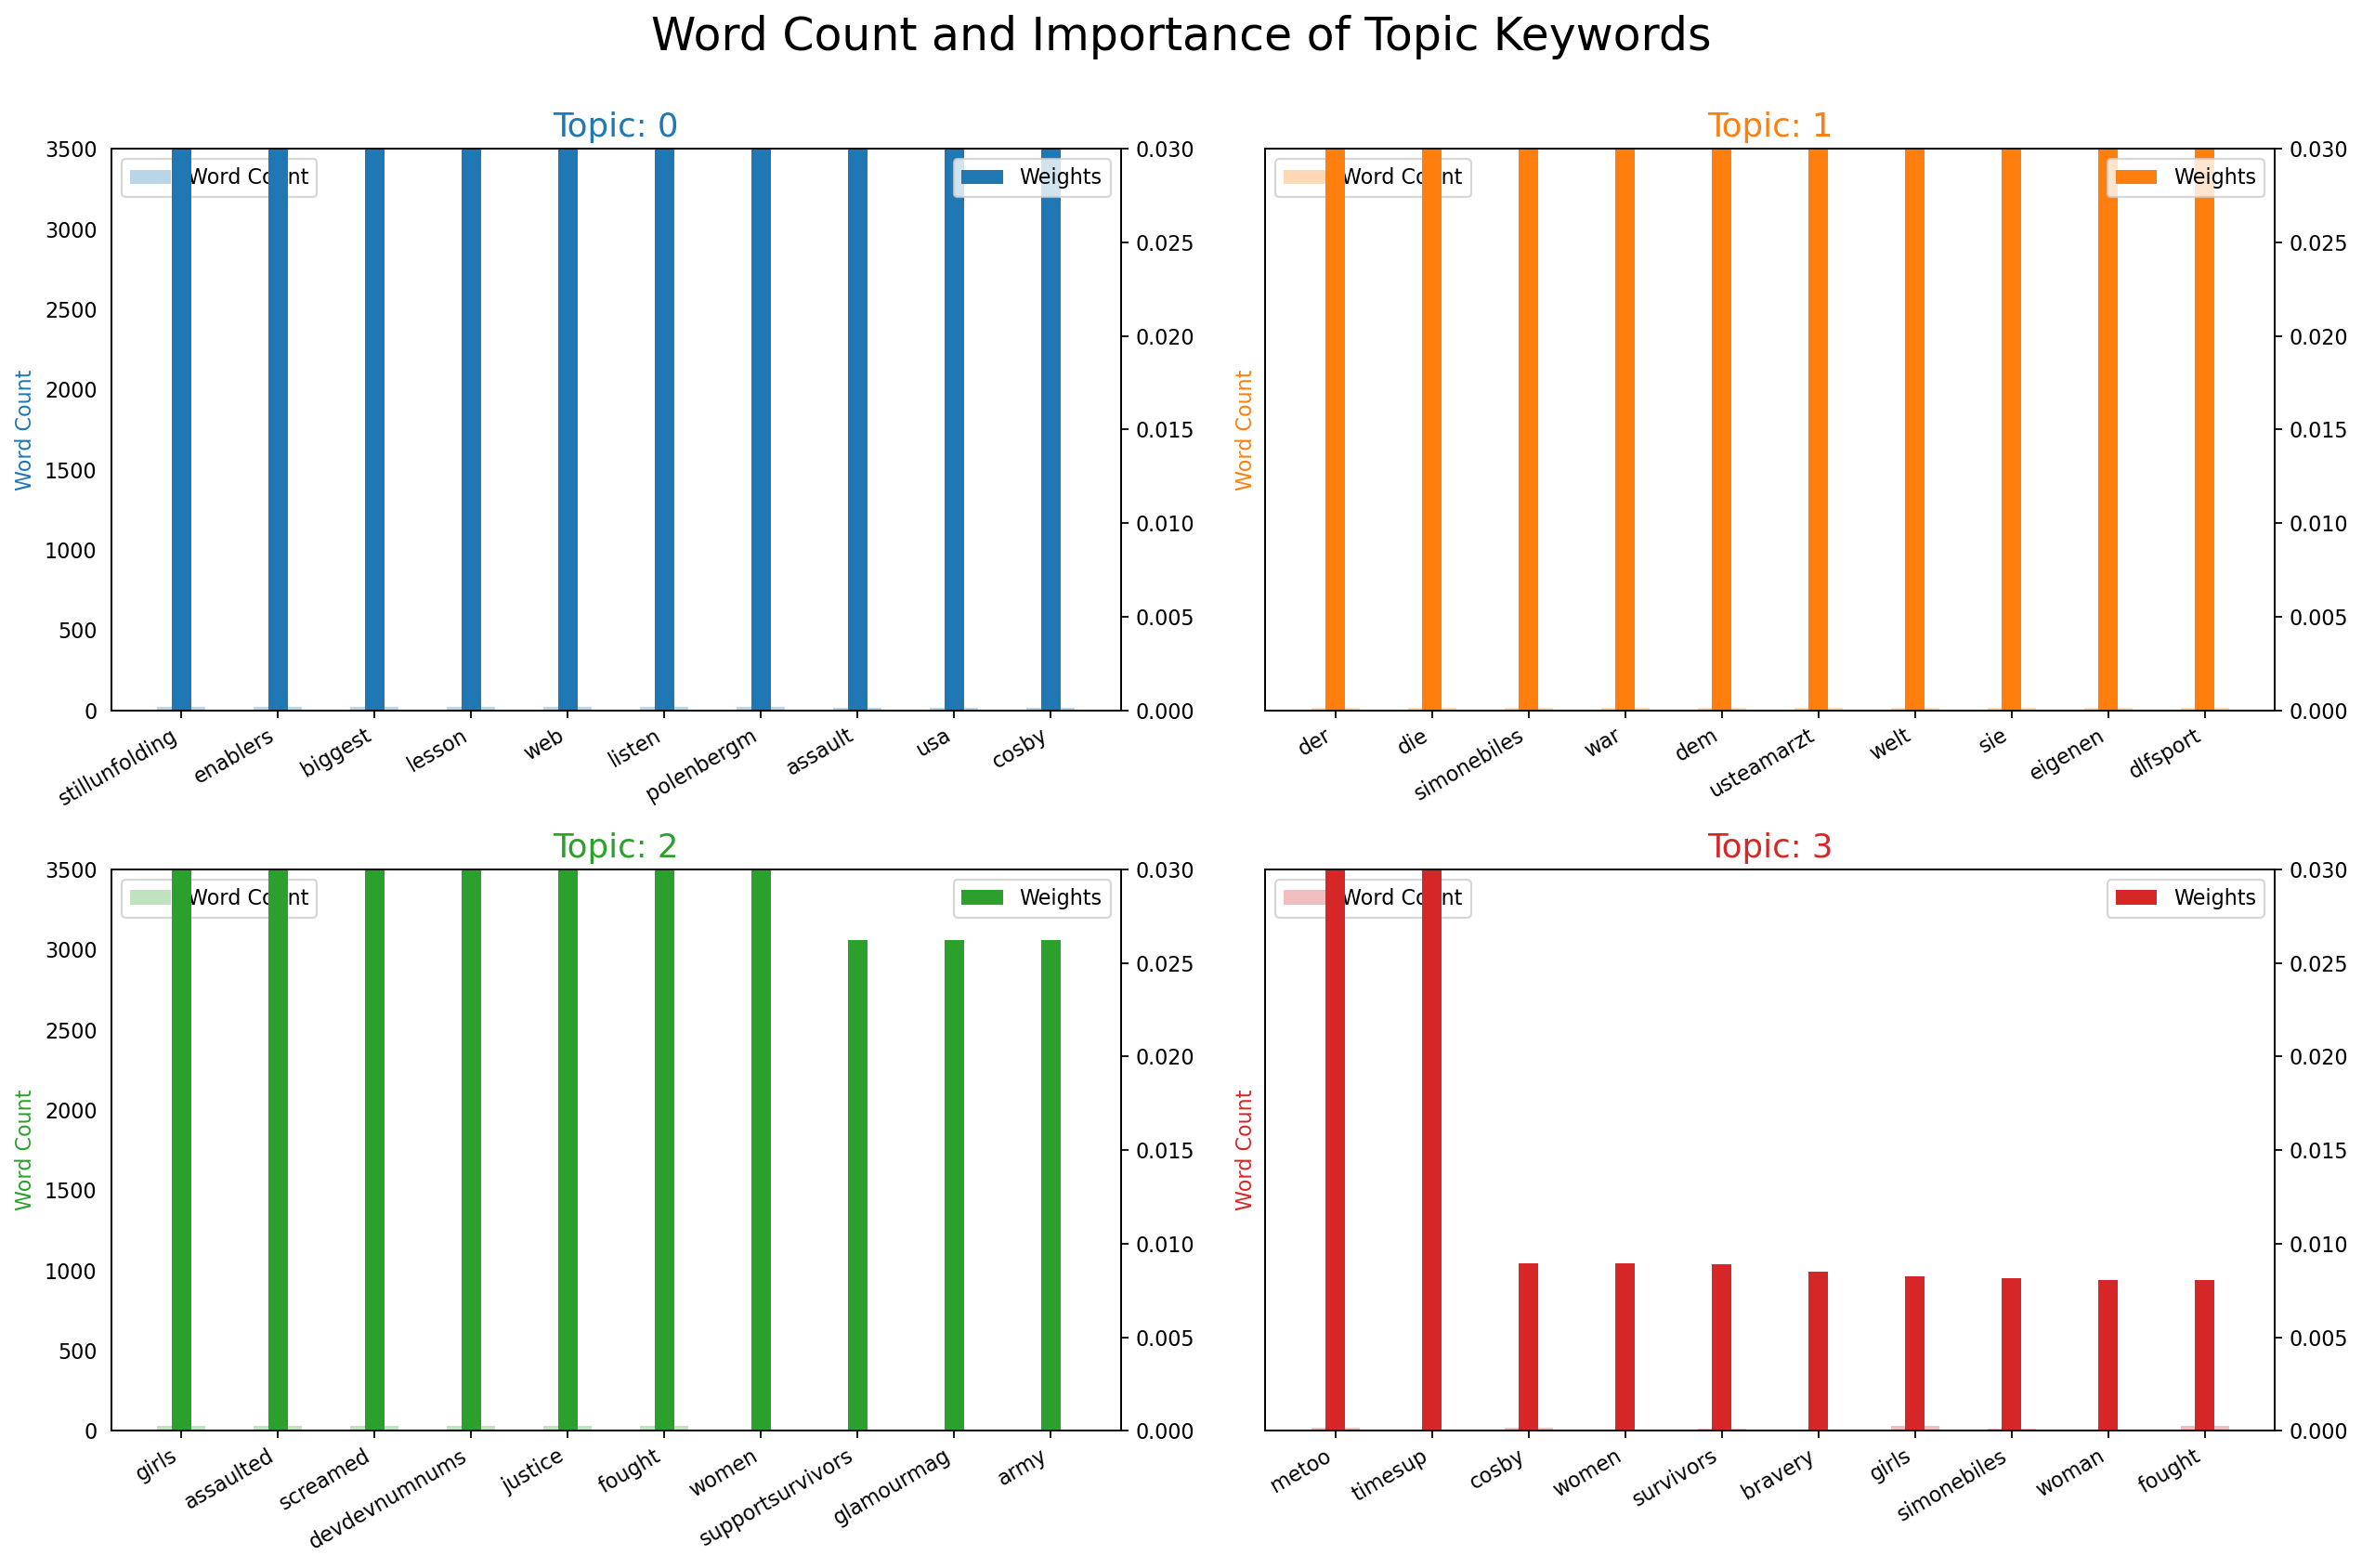

In [46]:
ldaDf = ldaToDf(ldamodel, tokList)
wordCountWeightPlot(ldaDf)

In [47]:
# clean up suspect-related stopwords
for word in suspectPattern["LarryNassar"].split("|"):
    stopWords.remove(word)

## Mark Halperin

#### sentiment analysis label counts

In [48]:
targetDF, targetList = suspectMap["MarkHalperin"]
tokenizedText, tokList = getTokenizedText(targetDF)

In [49]:
sentScore = getSentimentScore(tokenizedText)
sentScore["label"] = sentScore.apply(label_sentiment, axis=1)
display(sentScore)

,neg,neu,pos,compound,text,label
0,0.000,0.787,0.213,0.4019,jonbassett6 masg66 morningmika markhalperin jo...,pos
1,0.000,0.787,0.213,0.4019,jonbassett6 masg66 morningmika markhalperin jo...,pos
2,0.000,0.787,0.213,0.4019,jonbassett6 masg66 morningmika markhalperin jo...,pos
3,0.425,0.575,0.000,-0.8126,lynnshawprod managed book deal mark halperin m...,neg
4,0.425,0.575,0.000,-0.8126,lynnshawprod managed book deal mark halperin m...,neg
5,0.425,0.575,0.000,-0.8126,lynnshawprod managed book deal mark halperin m...,neg
6,0.000,1.000,0.000,0.0000,mrernestowens list harvey weinstein charlie ro...,neu
7,0.000,1.000,0.000,0.0000,mrernestowens list harvey weinstein charlie ro...,neu
8,0.000,1.000,0.000,0.0000,mrernestowens list harvey weinstein charlie ro...,neu
9,0.290,0.710,0.000,-0.5994,refocuszone karma deserved disgraced liberal p...,neg


In [50]:
display(sentScore["label"].value_counts().to_frame().rename(columns = {'label':'count'}))
display(sentScore["label"].value_counts(normalize=True).to_frame().rename(columns = {'label':'ratio'}))

,count
neu,17
pos,6
neg,5


,ratio
neu,0.607143
pos,0.214286
neg,0.178571


#### Sentiment analysis for top 5 [organization/community ] in each suspect

In [51]:
score, orgList = sentimentScoreByOrg(targetList)

top 1 organization/community: theblaze
number of retweets: 14
avg positive score: 0.0, avg negative score: 0.0, avg neutral score: 1.0

top 2 organization/community: MrErnestOwens
number of retweets: 3
avg positive score: 0.0, avg negative score: 0.0, avg neutral score: 1.0

top 3 organization/community: LynnShawProd
number of retweets: 3
avg positive score: 0.0, avg negative score: 0.40199999999999997, avg neutral score: 0.598

top 4 organization/community: Jonbassett6
number of retweets: 3
avg positive score: 0.213, avg negative score: 0.0, avg neutral score: 0.787

top 5 organization/community: Cajsa
number of retweets: 3
avg positive score: 0.127, avg negative score: 0.09000000000000001, avg neutral score: 0.783



#### word cloud analysis for each suspect using pretrained LDA model

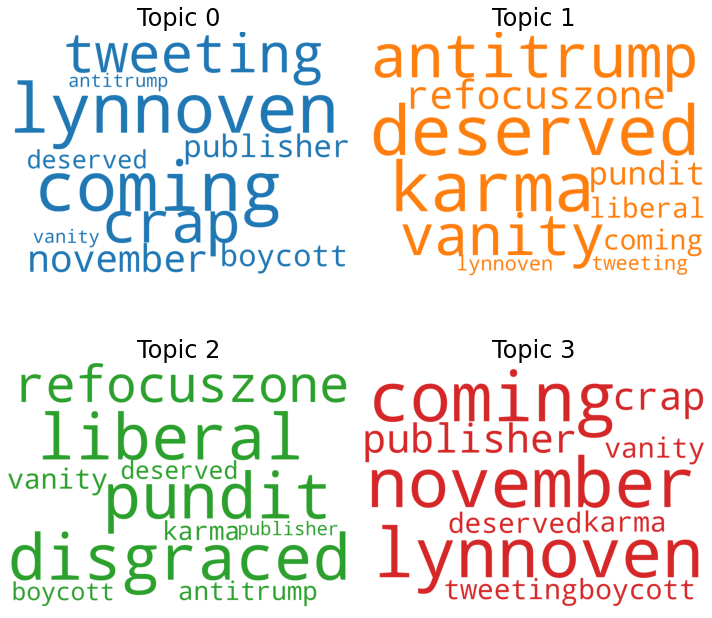

In [52]:
for word in suspectPattern["MarkHalperin"].split("|"):
    stopWords.add(word)
    
ldamodel = getLdaModel(tokList, topicNum=2, wordNum=2, no_below=1, no_above=0.1)
wordCloudPlot(ldamodel, stopWords)

/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalig

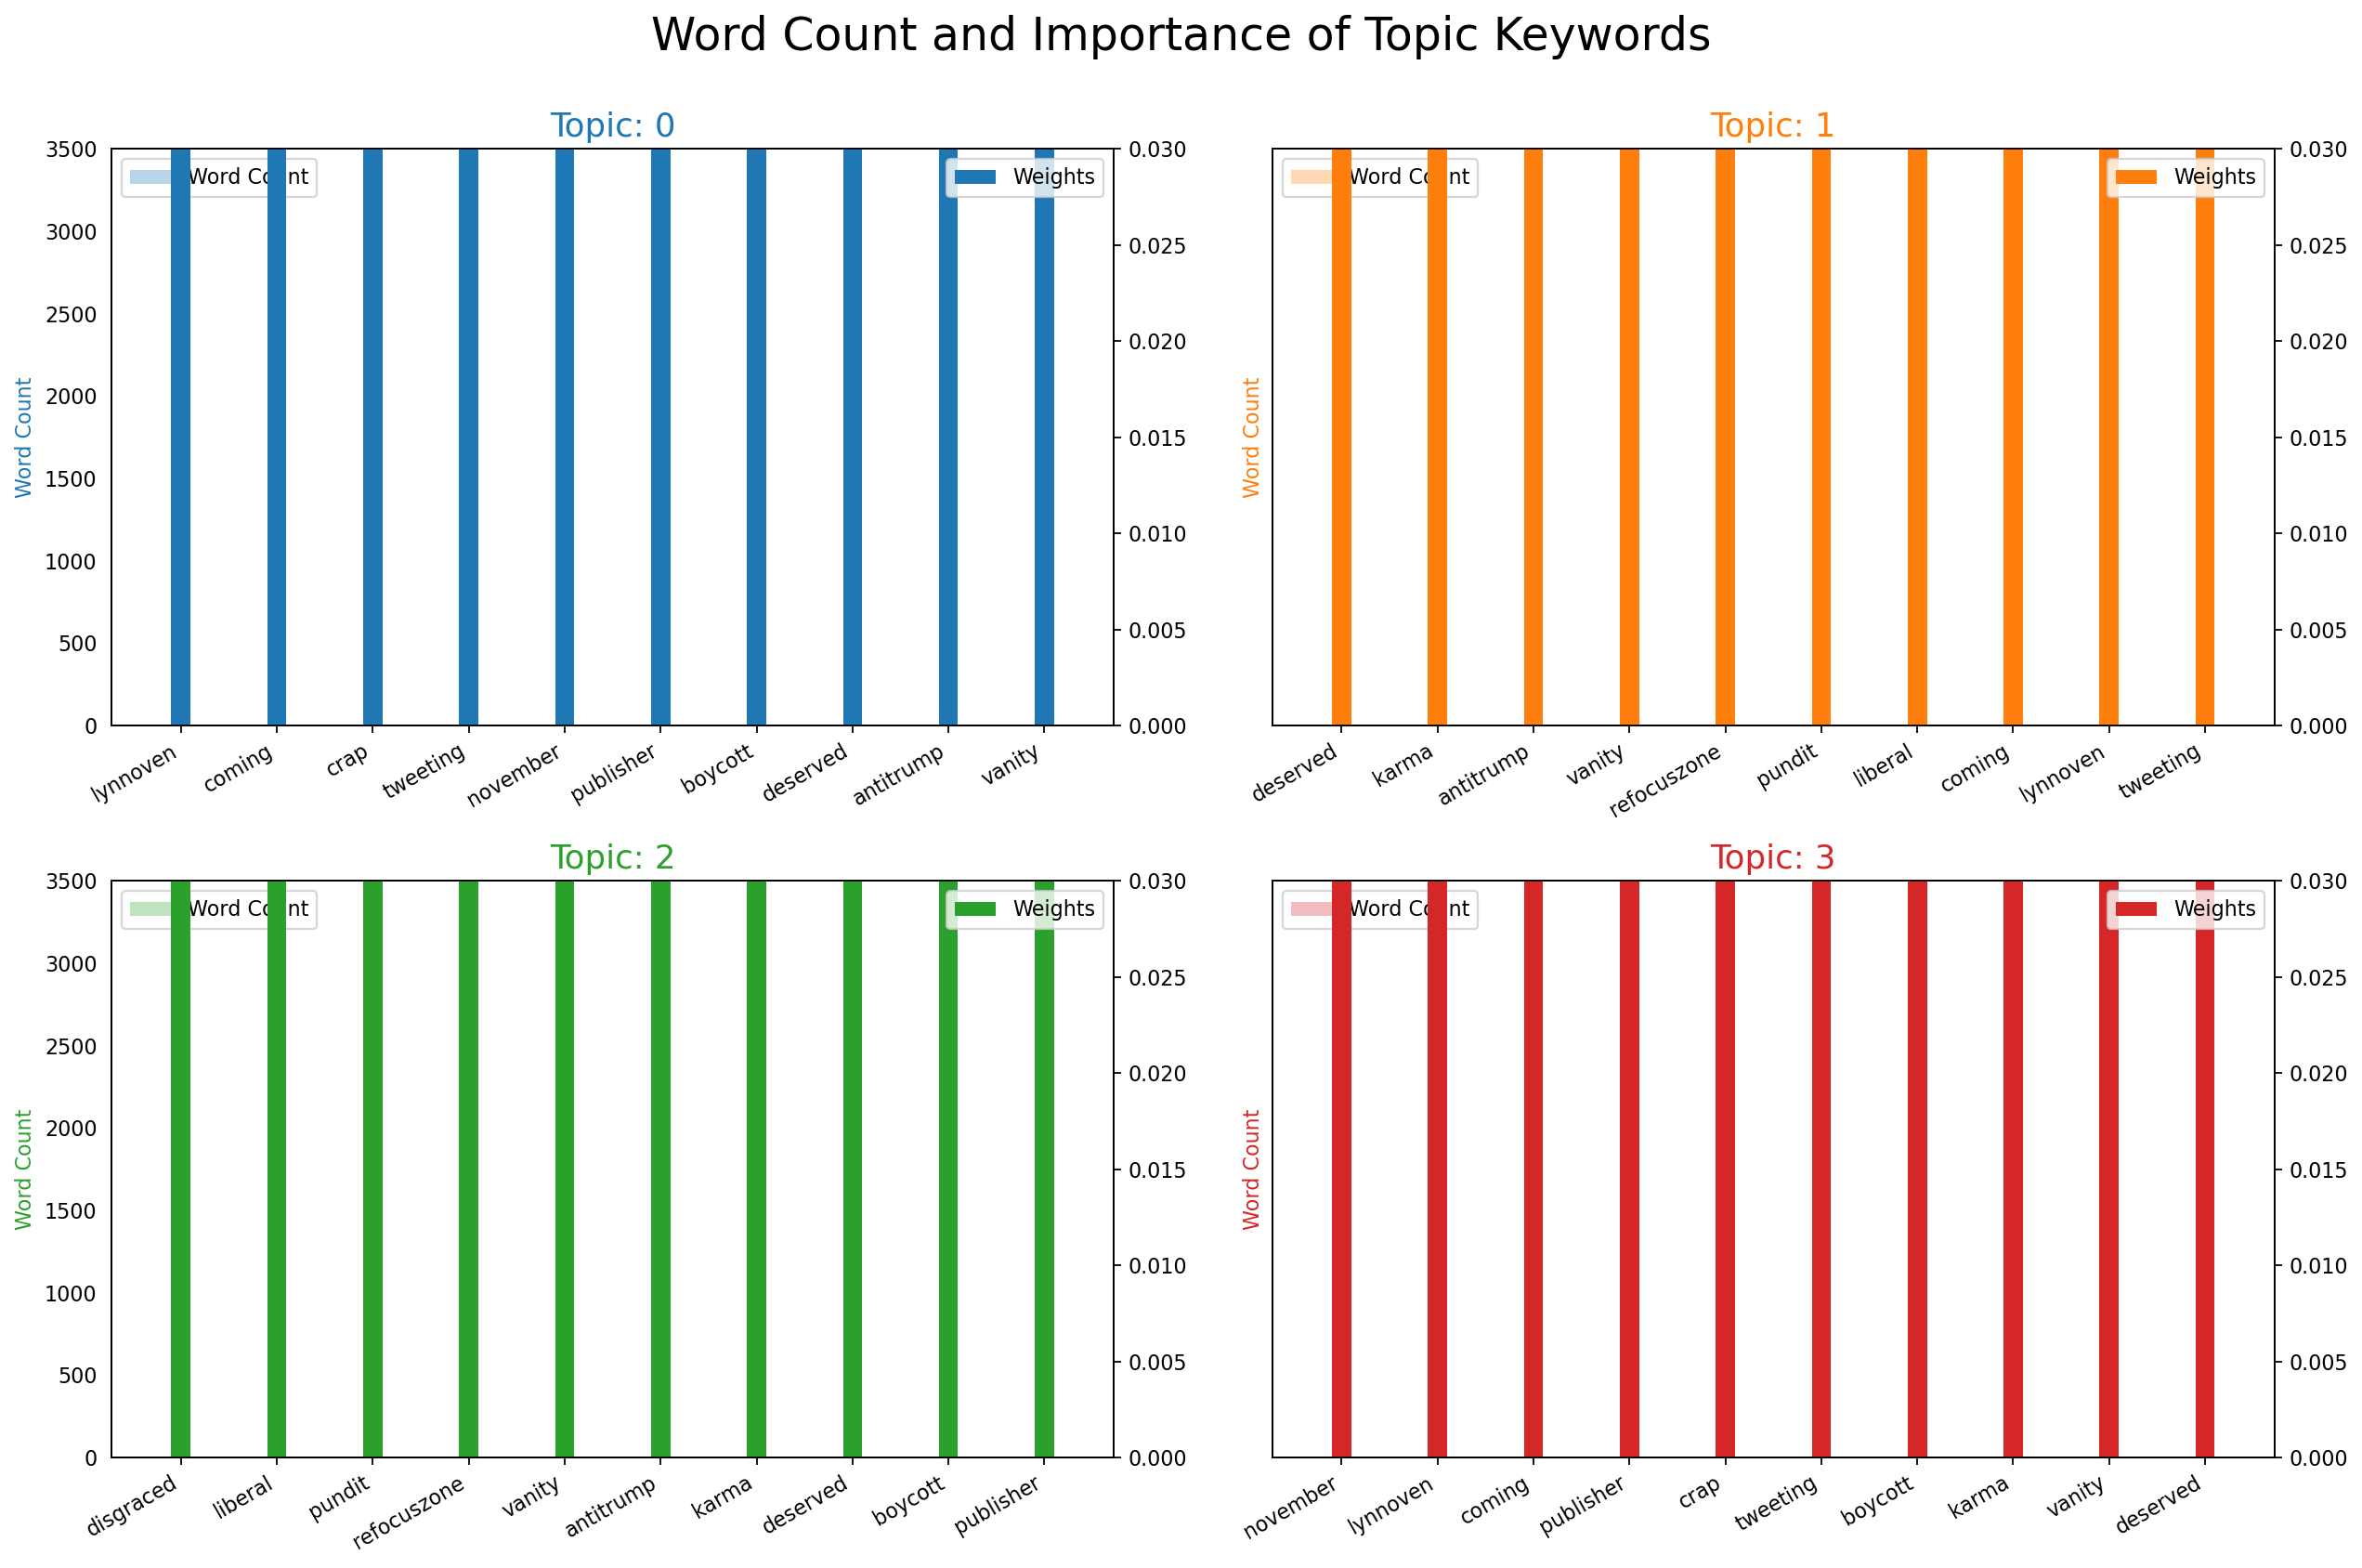

In [53]:
ldaDf = ldaToDf(ldamodel, tokList)
wordCountWeightPlot(ldaDf)

In [54]:
# clean up suspect-related stopwords
for word in suspectPattern["MarkHalperin"].split("|"):
    stopWords.remove(word)

## Neil deGrasse Tyson

#### sentiment analysis label counts

In [55]:
targetDF, targetList = suspectMap["NeildeGrasseTyson"]
tokenizedText, tokList = getTokenizedText(targetDF)

In [56]:
sentScore = getSentimentScore(tokenizedText)
sentScore["label"] = sentScore.apply(label_sentiment, axis=1)
display(sentScore)

,neg,neu,pos,compound,text,label
0,0.000,0.403,0.597,0.7506,netvoidglobal neiltyson yes articulate solidar...,pos
1,0.000,1.000,0.000,0.0000,gennygoat neiltyson women comprise half worlds...,neu
2,0.000,1.000,0.000,0.0000,aylwood astrophysicist neil degrasse tyson tar...,neu
3,0.262,0.738,0.000,-0.4939,evillyte neiltyson quotes surrounding metoo su...,neg
4,0.000,1.000,0.000,0.0000,wswsupdates astrophysicist neil degrasse tyson...,neu
5,0.231,0.769,0.000,-0.4023,marybasque broncosrings neiltyson metoo hang w...,neg
6,0.407,0.593,0.000,-0.5859,dudropz neiltyson sorry happened tyson midst m...,neg
7,0.231,0.769,0.000,-0.4023,marybasque broncosrings neiltyson metoo hang w...,neg
8,0.000,1.000,0.000,0.0000,marybasque broncosrings neiltyson isnt sexual ...,neu
9,0.000,1.000,0.000,0.0000,marybasque broncosrings neiltyson isnt sexual ...,neu


In [57]:
display(sentScore["label"].value_counts().to_frame().rename(columns = {'label':'count'}))
display(sentScore["label"].value_counts(normalize=True).to_frame().rename(columns = {'label':'ratio'}))

,count
neu,9
neg,7
pos,3


,ratio
neu,0.473684
neg,0.368421
pos,0.157895


#### Sentiment analysis for top 5 [organization/community ] in each suspect

In [58]:
score, orgList = sentimentScoreByOrg(targetList)

top 1 organization/community: MaryBasque
number of retweets: 4
avg positive score: 0.0, avg negative score: 0.092, avg neutral score: 0.9079999999999999

top 2 organization/community: FallingBodies
number of retweets: 2
avg positive score: 0.0, avg negative score: 0.0, avg neutral score: 1.0

top 3 organization/community: WSWS_Updates
number of retweets: 2
avg positive score: 0.0, avg negative score: 0.0, avg neutral score: 1.0

top 4 organization/community: Lokcrezia
number of retweets: 2
avg positive score: 0.162, avg negative score: 0.21750000000000003, avg neutral score: 0.621

top 5 organization/community: JuananNuevo
number of retweets: 1
avg positive score: 0.0, avg negative score: 0.0, avg neutral score: 1.0



#### word cloud analysis for each suspect using pretrained LDA model

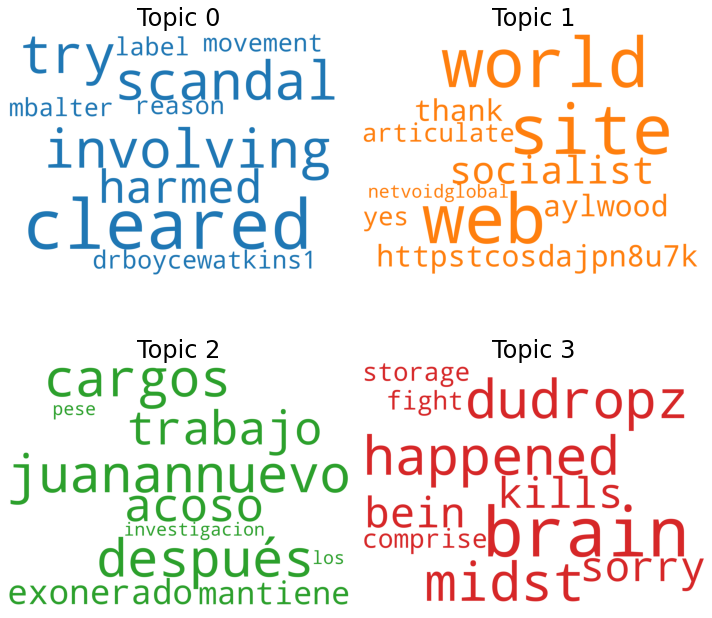

In [59]:
for word in suspectPattern["NeildeGrasseTyson"].split("|"):
    stopWords.add(word)
    
ldamodel = getLdaModel(tokList, topicNum=2, wordNum=2, no_below=1, no_above=0.1)
wordCloudPlot(ldamodel, stopWords)

/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalig

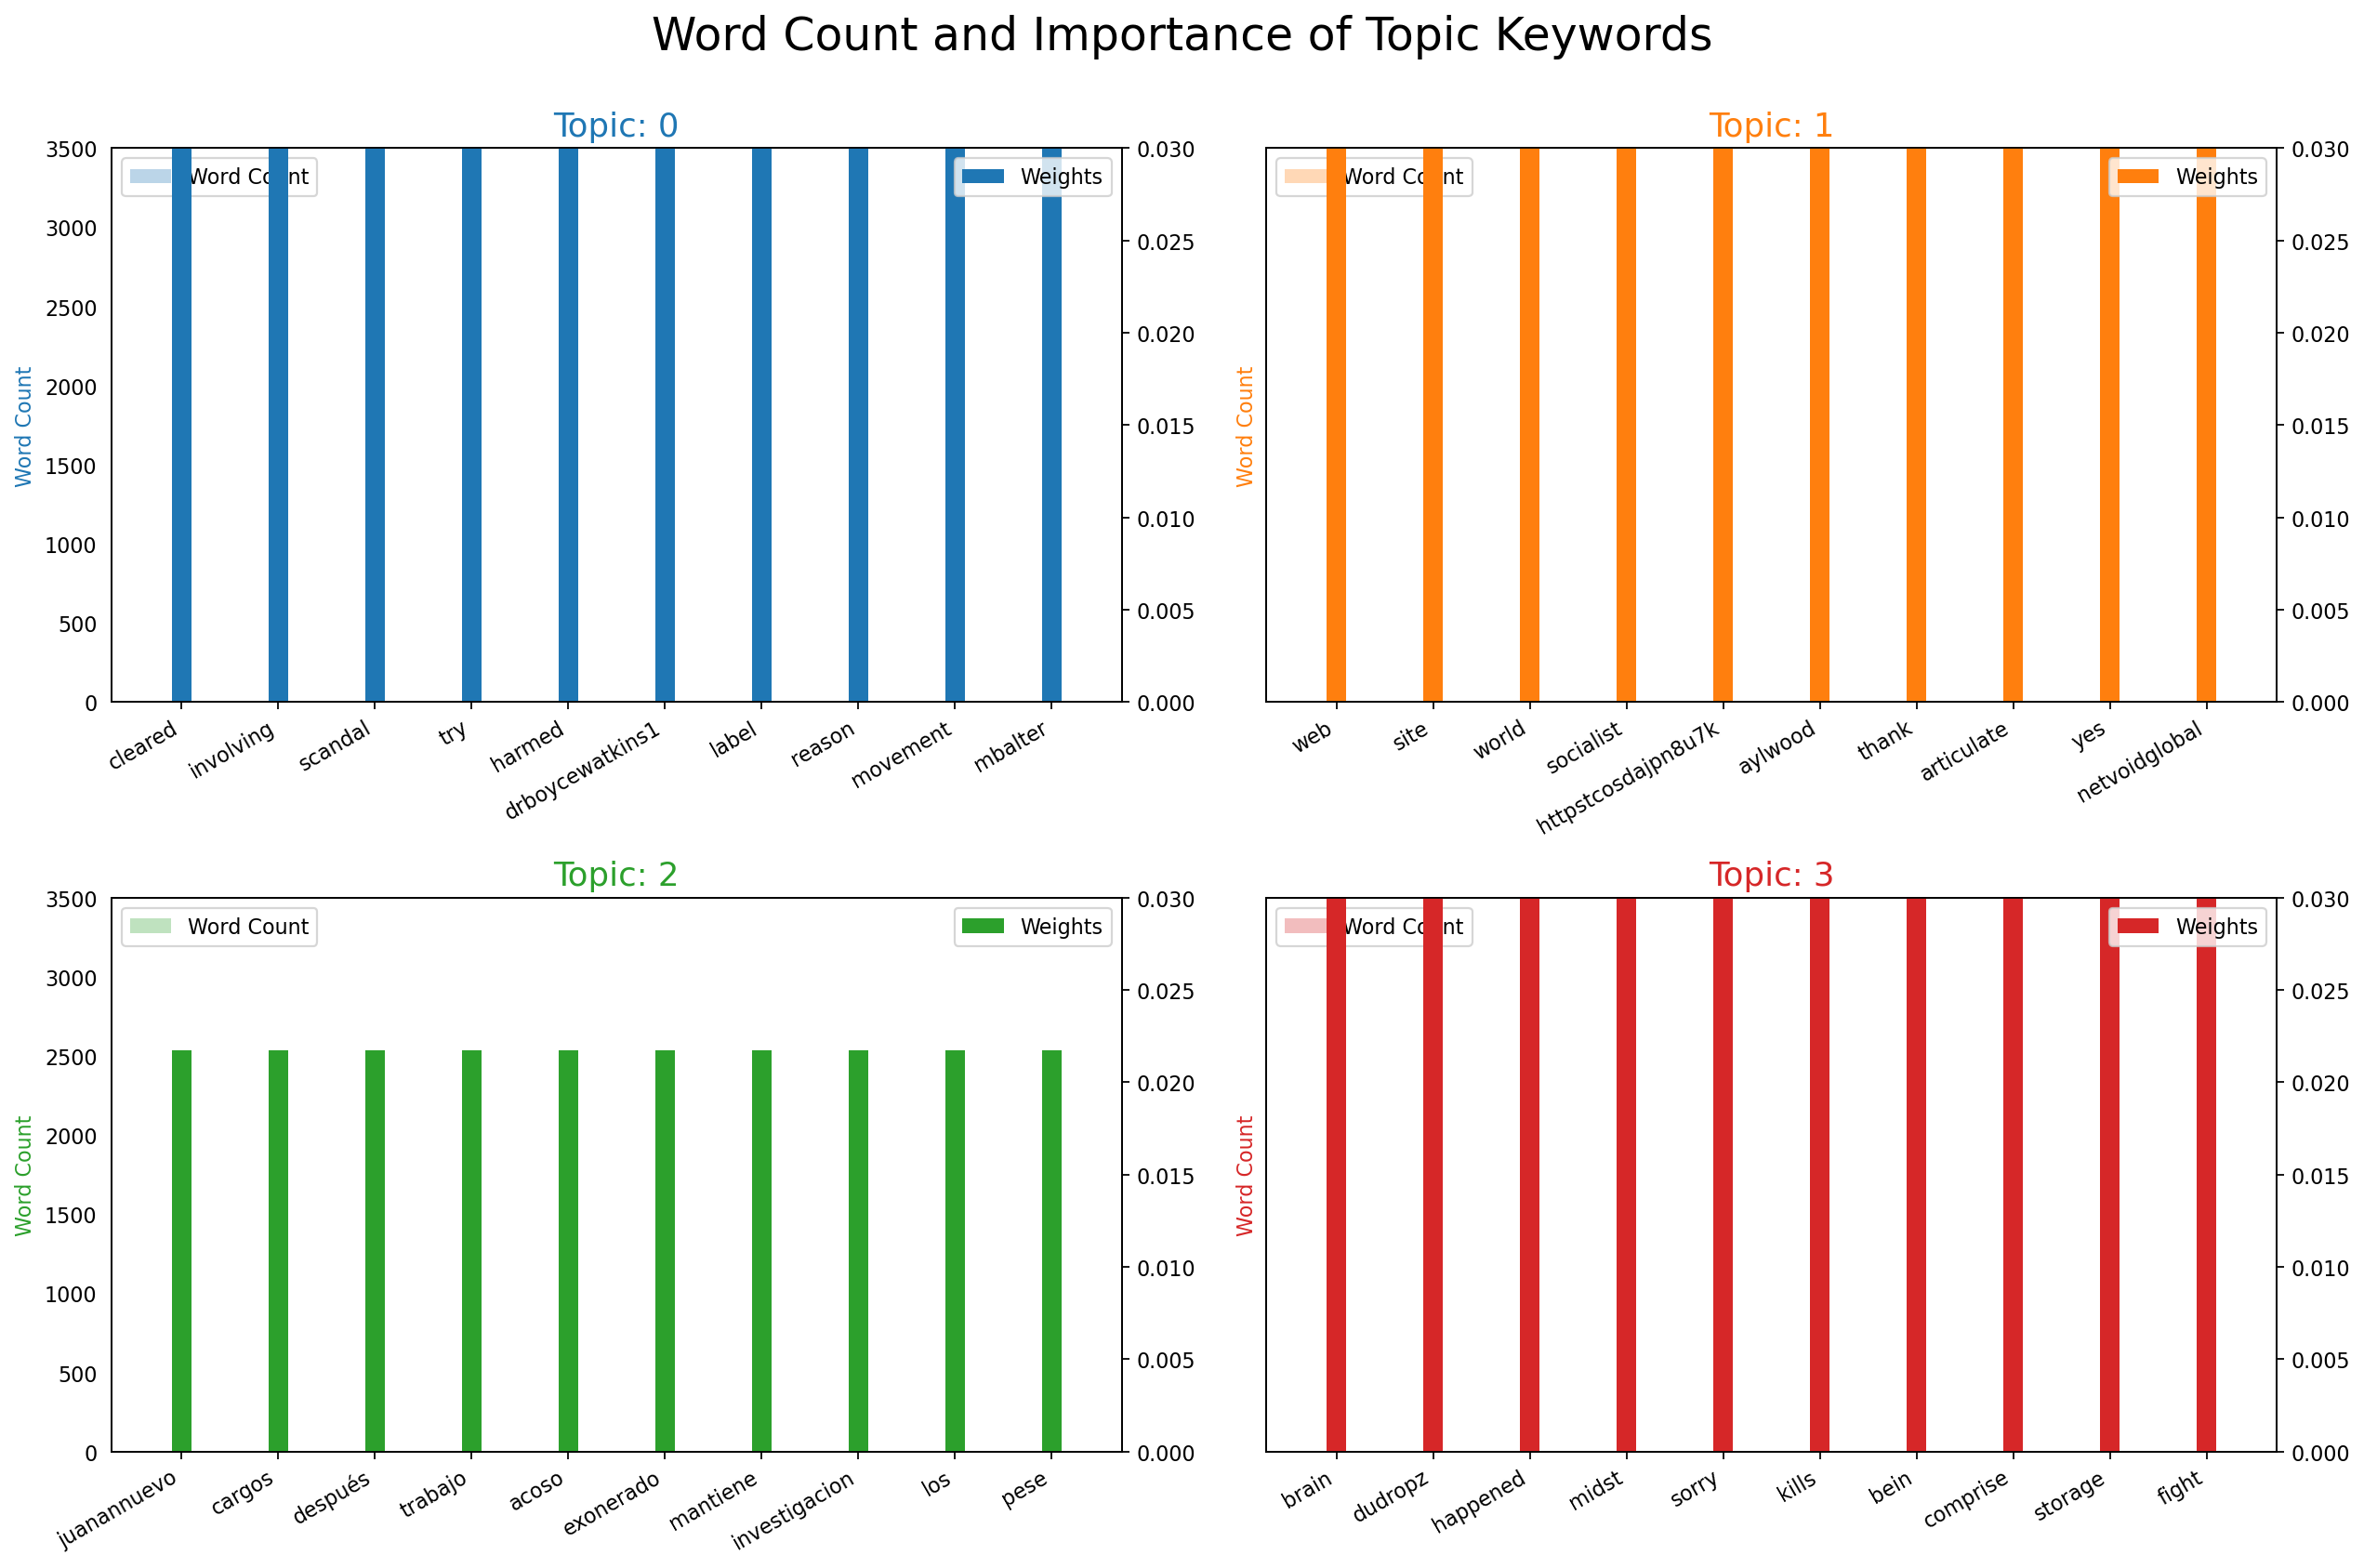

In [60]:
ldaDf = ldaToDf(ldamodel, tokList)
wordCountWeightPlot(ldaDf)

In [61]:
# clean up suspect-related stopwords
for word in suspectPattern["NeildeGrasseTyson"].split("|"):
    stopWords.remove(word)

## Matt Lauer

#### sentiment analysis label counts

In [62]:
targetDF, targetList = suspectMap["MattLauer"]
tokenizedText, tokList = getTokenizedText(targetDF)

In [63]:
sentScore = getSentimentScore(tokenizedText)
sentScore["label"] = sentScore.apply(label_sentiment, axis=1)
display(sentScore)

,neg,neu,pos,compound,text,label
0,0.247,0.753,0.000,-0.5574,thetornadonews life former host matt lauer fir...,neg
1,0.000,1.000,0.000,0.0000,bizzwriter sudden fall matt lauer charlie rose...,neu
2,0.000,1.000,0.000,0.0000,mcleanmills7 sudden fall matt lauer charlie ro...,neu
3,0.000,0.753,0.247,0.3182,themyscirablog matt lauer clinton tell qualifi...,pos
4,0.000,1.000,0.000,0.0000,publicsexcrimes görlitz syrischer asylbewerber...,neu
...,...,...,...,...,...,...
88,0.195,0.805,0.000,-0.4404,behroozparhami apple muchanticipated metoo dra...,neg
89,0.000,1.000,0.000,0.0000,tvmcca caitlin flanagan matt lauer women atlan...,neu
90,0.570,0.430,0.000,-0.6486,janettewms victim blaming mattlauer metoo http...,neg
91,0.268,0.732,0.000,-0.5106,themyscirablog moment address pervert enablers...,neg


In [64]:
display(sentScore["label"].value_counts().to_frame().rename(columns = {'label':'count'}))
display(sentScore["label"].value_counts(normalize=True).to_frame().rename(columns = {'label':'ratio'}))

,count
neu,57
neg,18
pos,18


,ratio
neu,0.612903
neg,0.193548
pos,0.193548


#### Sentiment analysis for top 5 [organization/community ] in each suspect

In [65]:
score, orgList = sentimentScoreByOrg(targetList)

top 1 organization/community: PublicSexCrimes
number of retweets: 16
avg positive score: 0.0, avg negative score: 0.0, avg neutral score: 1.0

top 2 organization/community: CNNEE
number of retweets: 13
avg positive score: 0.0, avg negative score: 0.0, avg neutral score: 1.0

top 3 organization/community: RealCandaceO
number of retweets: 8
avg positive score: 0.0975, avg negative score: 0.16425, avg neutral score: 0.73825

top 4 organization/community: AmySpiro
number of retweets: 7
avg positive score: 0.0, avg negative score: 0.0, avg neutral score: 1.0

top 5 organization/community: Zigmanfreud
number of retweets: 5
avg positive score: 0.327, avg negative score: 0.0, avg neutral score: 0.673



#### word cloud analysis for each suspect using pretrained LDA model

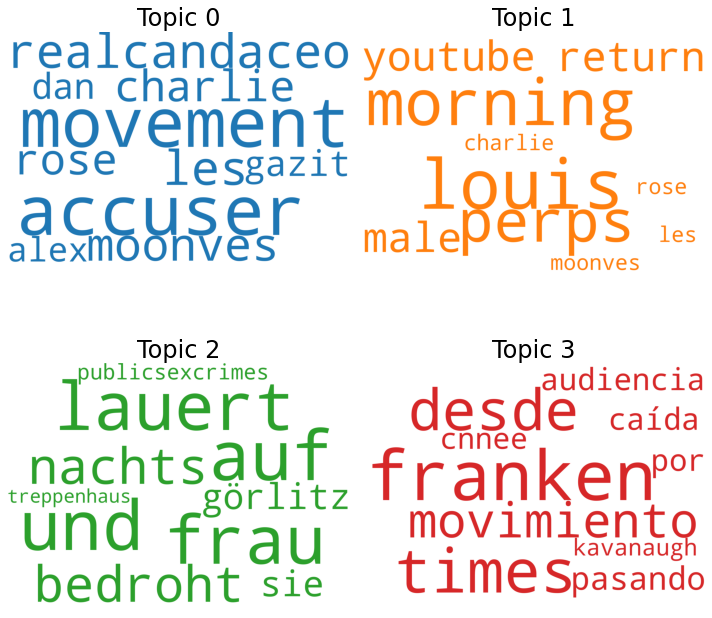

In [66]:
for word in suspectPattern["MattLauer"].split("|"):
    stopWords.add(word)
    
ldamodel = getLdaModel(tokList)
wordCloudPlot(ldamodel, stopWords)

/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/3r/myv7ss551dn8lj57f21vtw500000gn/T/ipykernel_93482/3676834916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalig

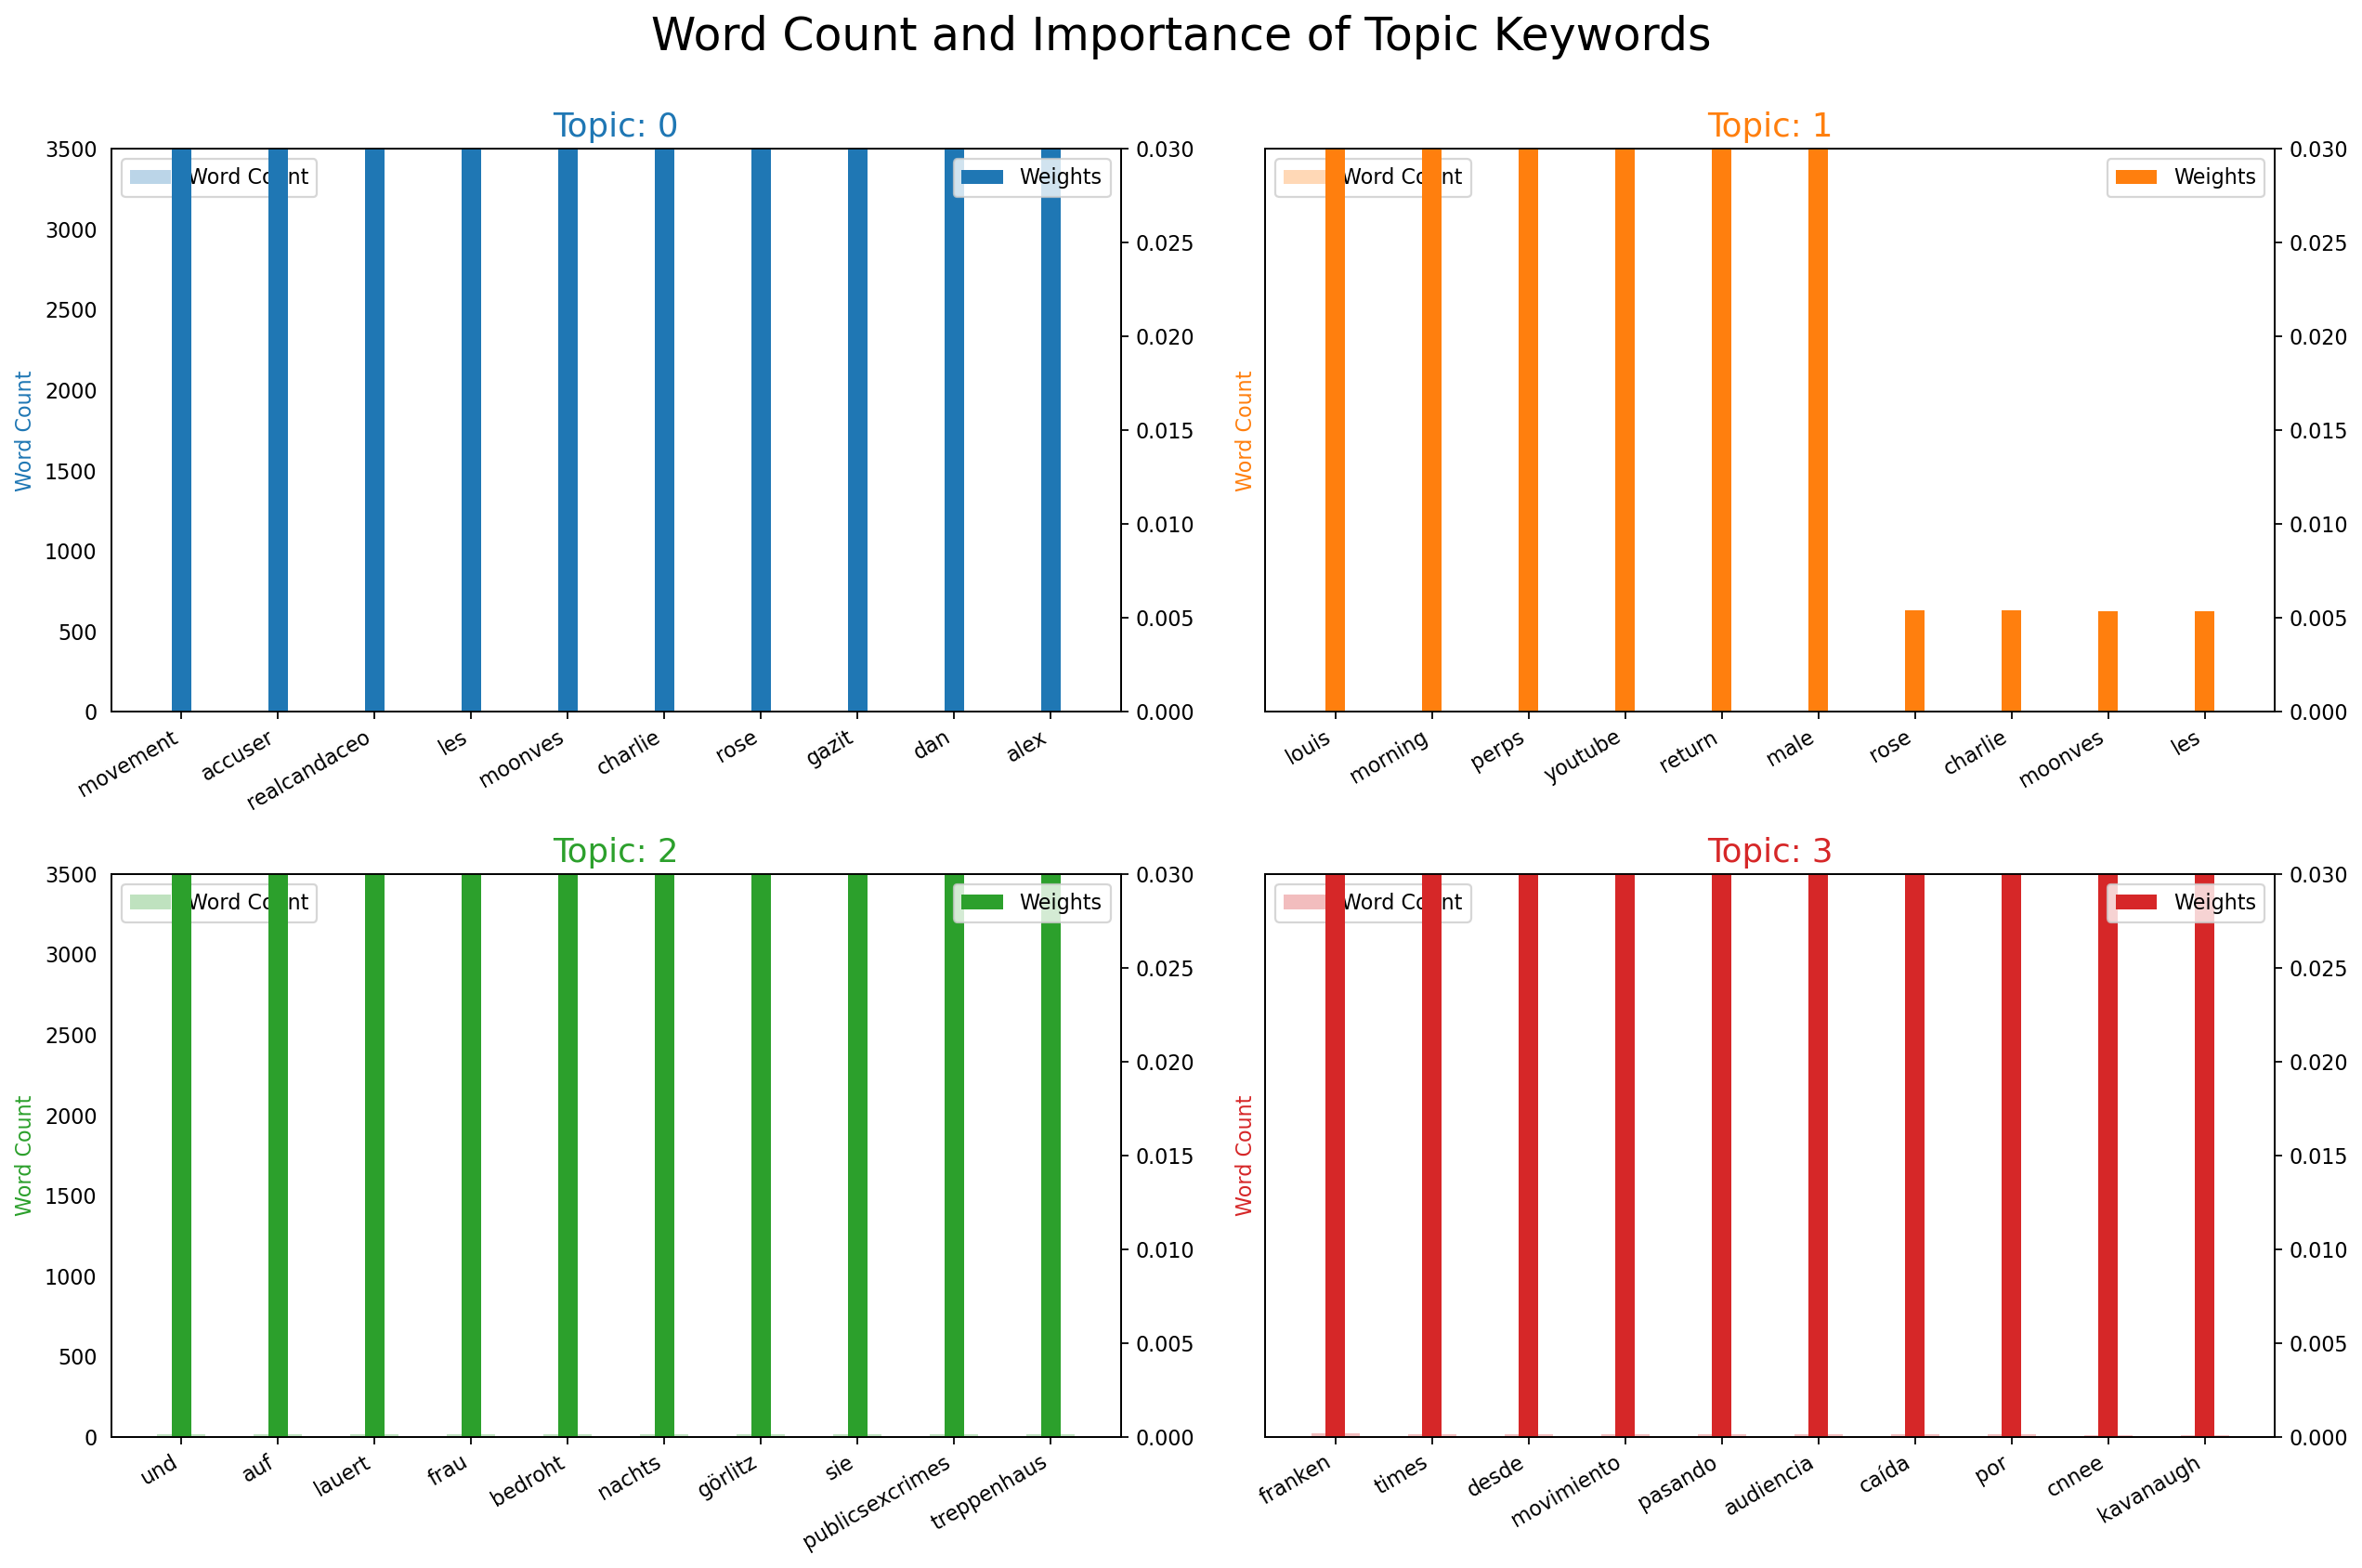

In [67]:
ldaDf = ldaToDf(ldamodel, tokList)
wordCountWeightPlot(ldaDf)

In [68]:
# clean up suspect-related stopwords
for word in suspectPattern["MattLauer"].split("|"):
    stopWords.remove(word)